### Differential expression analysis using DEseq when considering timestamp as an independent variable

Create count table for each comparison 

In [14]:
import glob
import re
import pandas as pd

def control_files(directory, name):
    item = ['activated_sorted', 'Sample1']
    control = [f for f in glob.glob(directory + '/' + name + '*' + '.featurecounts.counts.txt') if all(i not in f for i in item)]
    return control

def get_files(file_dir, factor, file_ext):
    item = ['activated_sorted', 'Sorted']
    treat_files = [f for f in glob.glob(file_dir + '/' + factor + '.' + '*' + '.' + file_ext) if all(i not in f for i in item)] 
    all_files = treat_files + control_files("/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb", "mmTh0")
    return all_files

factor_files = {
    #'Th17-mmTh0': get_files("/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb", "Th17", "featurecounts.counts.txt"),
    'mmTreg-mmTh0': get_files("/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb", "mmTreg", "featurecounts.counts.txt"),
    #'pTh17-mmTh0': get_files("/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb", "pTh17", "featurecounts.counts.txt")
}


def clean_count_column(s):
    items = ['bulk', 'Bulk']
    name = '.'.join(s.split('/')[-1].split('.')[:3])
    if name.startswith('mm'):
        if any(i in s for i in items):
            return '.'.join(s.split('/')[-1].replace('.rna_seq.activated_bulk','.Bulk').replace('h.','hr.').split('.')[:4])
        else:
            return '.'.join(s.split('/')[-1].replace('.rna_seq.activated','.Bulk').replace('h.','hr.').split('.')[:4])
        
    else:
        if any(i in s for i in items):
            split_words = '.'.join(s.split('.')[1:3])
            rev_words = '.'.join(list(reversed(s.split('.')[1:3])))
            return '.'.join(s.split('/')[-1].replace(split_words, rev_words).split('.')[:4])
        else:
            s = re.sub('17.', '17.Bulk.', s)
            return '.'.join(s.split('/')[-1].split('.')[:4])
        

for factor, files in factor_files.items():
    df = None
    for f in files:
        df_tmp = pd.read_csv(f, sep='\t', skiprows=1, index_col=0)
        df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_count_column(f)]
        if df is None:
            df = df_tmp.loc[:, ['Chr', 'Start', 'End'] + [df_tmp.columns[-1]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-1]], how='right')

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='int')

    df.to_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/%s.counts.txt' % factor, sep='\t')

DE analysis - DESeq2 - with PCA plots for each time point

In [2]:
%%writefile /data/reddylab/Revathy/scripts/rnaseq_dge.deseq2_pca_time.R
#!/usr/bin/env Rscript
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(matrixStats))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library("argparse"))

# Rewrite DESeq2 plotPCA function to specify which PC to plot
plotPCA_ = function(object, intgroup="condition", ntop=500, returnData=FALSE, pcX=1, pcY=2, ignoreReps=FALSE)
{
  # calculate the variance for each gene
  rv <- rowVars(assay(object))

  # select the ntop genes by variance
  select <- order(rv, decreasing=TRUE)[seq_len(min(ntop, length(rv)))]

  # perform a PCA on the data in assay(x) for the selected genes
  pca <- prcomp(t(assay(object)[select,]))

  # the contribution to the total variance for each component
  percentVar <- pca$sdev^2 / sum( pca$sdev^2 )

  if (!all(intgroup %in% names(colData(object)))) {
    stop("the argument 'intgroup' should specify columns of colData(dds)")
  }

  intgroup.df <- as.data.frame(colData(object)[, intgroup, drop=FALSE])
  
  # add the intgroup factors together to create a new grouping factor
  group <- if (length(intgroup) > 1) {
    factor(apply( intgroup.df, 1, paste, collapse=":"))
  } else {
    colData(object)[[intgroup]]
  }
    
  if (returnData) {
    attr(d, "percentVar") <- c(percentVar[pcX], percentVar[pcY])
    return(d)
  }
  rep <- colData(object)[['rep']]
#   rep <- row.names(colData(dds))
  if (!ignoreReps){
      # Add replicate info
#       rep <- colData(object)[['rep']]

        # assembly the data for the plot
      d <- data.frame(PCX=pca$x[,pcX], PCY=pca$x[,pcY], group=group, rep=rep, intgroup.df, name=colnames(object))

      ggplot(data=d, aes_string(x="PCX", y="PCY", color="group", shape="rep")) + geom_point(size=3) + 
        xlab(paste0("PC", pcX, ": ",round(percentVar[pcX] * 100),"% variance")) +
          ylab(paste0("PC", pcY, ": ",round(percentVar[pcY] * 100),"% variance")) +
      scale_shape_manual(values=seq(0,15))
  } else {
#       batch <- as.factor(colData(object)[['batch']])
        # assembly the data for the plot
      d <- data.frame(PCX=pca$x[,pcX], PCY=pca$x[,pcY], group=group, intgroup.df, name=colnames(object))

      ggplot(data=d, aes_string(x="PCX", y="PCY", color="group")) + 
          geom_point(size=3) +
          geom_text(aes(label=rep),hjust=0, vjust=0) +
          xlab(paste0("PC", pcX, ": ",round(percentVar[pcX] * 100),"% variance")) +
          ylab(paste0("PC", pcY, ": ",round(percentVar[pcY] * 100),"% variance")) +
      scale_shape_manual(values=seq(0,15))
  }
#     + coord_fixed()
}

# Rewrite DESeq2 plotPCA function to specify which PC to plot
plotPCA_time = function(object, intgroup="condition", ntop=500, returnData=FALSE, pcX=1, pcY=2, ignoreTime=FALSE)
{
  # calculate the variance for each gene
  rv <- rowVars(assay(object))

  # select the ntop genes by variance
  select <- order(rv, decreasing=TRUE)[seq_len(min(ntop, length(rv)))]

  # perform a PCA on the data in assay(x) for the selected genes
  pca <- prcomp(t(assay(object)[select,]))

  # the contribution to the total variance for each component
  percentVar <- pca$sdev^2 / sum( pca$sdev^2 )

  if (!all(intgroup %in% names(colData(object)))) {
    stop("the argument 'intgroup' should specify columns of colData(dds)")
  }

  intgroup.df <- as.data.frame(colData(object)[, intgroup, drop=FALSE])
  
  # add the intgroup factors together to create a new grouping factor
  group <- if (length(intgroup) > 1) {
    factor(apply( intgroup.df, 1, paste, collapse=":"))
  } else {
    colData(object)[[intgroup]]
  }
    
  if (returnData) {
    attr(d, "percentVar") <- c(percentVar[pcX], percentVar[pcY])
    return(d)
  }
  time <- colData(object)[['time']]
#   rep <- row.names(colData(dds))
  if (!ignoreTime){
      # Add replicate info
#       rep <- colData(object)[['rep']]

        # assembly the data for the plot
      d <- data.frame(PCX=pca$x[,pcX], PCY=pca$x[,pcY], group=group, time=time, intgroup.df, name=colnames(object))

      ggplot(data=d, aes_string(x="PCX", y="PCY", color="group", shape="time")) + geom_point(size=3) + 
        xlab(paste0("PC", pcX, ": ",round(percentVar[pcX] * 100),"% variance")) +
          ylab(paste0("PC", pcY, ": ",round(percentVar[pcY] * 100),"% variance")) +
      scale_shape_manual(values=seq(0,15))
  } else {
#       batch <- as.factor(colData(object)[['batch']])
        # assembly the data for the plot
      d <- data.frame(PCX=pca$x[,pcX], PCY=pca$x[,pcY], group=group, intgroup.df, name=colnames(object))

      ggplot(data=d, aes_string(x="PCX", y="PCY", color="group")) + 
          geom_point(size=3) +
          geom_text(aes(label=time),hjust=0, vjust=0) +
          xlab(paste0("PC", pcX, ": ",round(percentVar[pcX] * 100),"% variance")) +
          ylab(paste0("PC", pcY, ": ",round(percentVar[pcY] * 100),"% variance")) +
      scale_shape_manual(values=seq(0,15))
  }
#     + coord_fixed()
}



# create parser object
parser <- ArgumentParser()

# specify our desired options 
# by default ArgumentParser will add an help option 
parser$add_argument("-c", "--controls", nargs="+", help="Featurecounts file for controls")
parser$add_argument("-t", "--treatments", nargs="+", help="Featurecounts file for treatments")
parser$add_argument("--counts", nargs="+", help="Count matrix (or matrices). Count columns should match controls and treatments specified")
parser$add_argument("--outdir", help="Output directory where result files will be saved.")
parser$add_argument("--lfcShrink", required=F, 
                    help="Perform effect size shrinkage (types: normal, apeglm and ashr. See Zhu, Ibrahim, and Love 2018).")
parser$add_argument("--lib-sizes", required=F, 
                    help="Use library sizes as scaling factor overwritting the default total counts per library")
parser$add_argument("--counts-skip-ncols", required=F, 
                    help="Skip n first columns from count matrix")
parser$add_argument("--counts-only-treatments-and-controls", required=F, action="store_true", default=FALSE,
                    help="Keep only the counts from the treatment and control samples (affects dispersion estimates, but can speed up things significantly)")
parser$add_argument("--no-filter", required=F, action="store_true", default=FALSE,
                    help="By default, lowly expressed regions in only 1 sample are removed. Specify if no filter should be done")
parser$add_argument("--no-model-reps", required=F, action="store_true", default=FALSE,
                    help="Ignore replicates when plotting PCA components")
parser$add_argument("--norm-by-ercc", required=F, action="store_true", default=FALSE,
                    help="Normalized using ERCC counts (probes staring by ERCC-)")
parser$add_argument("--samples-info-df", required=F, default=FALSE,
                    help="Optionally, provide a DataFrame with sample info (which in DESeq2 is used as column data)")
parser$add_argument("--control-substr", required=F, default=FALSE,
                    help="Optionally, provide a substr found in rownames to identify control counts (e.g. housekeeping genes, spike-ins, etc.). It changes the estimateSizeFactors function")
parser$add_argument("--no-model-time", required=F, action="store_true", default=FALSE,
                    help="Ignore timepoints when plotting PCA components")


# get command line options, if help option encountered print help and exit,
# otherwise if options not found on command line then set defaults, 
args <- parser$parse_args()
treatments <- args$treatments
controls <- args$controls
outdir <- args$outdir

ff <- args$counts
dd <- lapply(ff, read.csv, header=TRUE, sep="\t", stringsAsFactors=FALSE, row.names=1)
xx <- do.call(cbind, dd)

countData <- xx
if (!is.null(args$counts_skip_ncols)){
    countData <- xx[, -c(1:args$counts_skip_ncols)]
}

colnames(countData)[colnames(countData)%in%append(treatments, controls)]
if (args$counts_only_treatments_and_controls){
#     countData <- xx %>% select(unlist(append(treatments, controls)))
    countData <- subset(xx, select = colnames(countData)[colnames(countData)%in%append(treatments, controls)])
}

controls
treatments
samples_no_reps <- gsub("(.*)\\..*", "\\1", colnames(countData))
reps <- gsub(".*\\.(.*)", "\\1", colnames(countData))
timepoints <- gsub(".*\\.(.*)", "\\1", samples_no_reps)
timepoints


conditions <- gsub("(.*)\\..*", "\\1", samples_no_reps)
conditions

if (args$samples_info_df){
    colData <- read.csv(args$samples_info_df, 
                        header=TRUE, sep="\t", 
                        stringsAsFactors=TRUE, row.names=1)
    colData <- colData[colnames(countData), ]
    design_formula_str <- paste(c("~ ", paste(colnames(colData), collapse = " + ")), collapse='')
    print(design_formula_str)
    dds <- DESeqDataSetFromMatrix(countData = countData,
                                  colData = colData,
                                  design = formula(design_formula_str))
} else {
    colData <- data.frame(condition=conditions, time=timepoints, rep=reps, row.names=colnames(countData)) 
    print(colData)
    if (!(args$no_model_reps)){
        print(reps)
    #     colData <- data.frame(condition=conditions, rep=reps, row.names=colnames(countData))
        dds <- DESeqDataSetFromMatrix(countData = countData,
                                      colData = colData,
                                      design = ~ rep + time + condition + time:condition)
    } else {
    #     colData <- data.frame(condition=conditions, row.names=colnames(countData))
        dds <- DESeqDataSetFromMatrix(countData = countData,
                                      colData = colData,
                                      design = ~ time + condition + time:condition)
    }
} 


# Optionally: if lib_sizes provided, manually assigned scale factors
if (!is.null(args$lib_sizes)){
    lib_sizes <- read.table(args$lib_sizes, sep="\t", row.names=1)
    lib_sizes <- lib_sizes[colnames(countData), ]
    lib_sizes_scale_factors <- lib_sizes/min(lib_sizes)
    sizeFactors(dds) <- lib_sizes_scale_factors    
}

if (args$norm_by_ercc){
    ercc_genes <- countData[grepl("^ERCC", rownames(countData)), ]
    dds <- DESeqDataSetFromMatrix(countData = countData[!grepl("^ERCC", rownames(countData)), ],
                              colData = colData,
                              design = ~ condition)
    ercc_dds <- DESeqDataSetFromMatrix(countData = ercc_genes, 
                                       colData = colData,
                                       design = ~ condition)
    sizeFactors(dds) <-  sizeFactors(estimateSizeFactors(ercc_dds))
}

# Reorder condition comparisons to always compute log2 fold changes of treat vs control
conditions_pair <- unique(conditions)
control <- gsub("(.*)\\..*", "\\1", controls)
control_conditions <- unique(gsub("(.*)\\..*", "\\1", control))
treatment <- gsub("(.*)\\..*", "\\1", treatments)
treatment_conditions <- unique(gsub("(.*)\\..*", "\\1", treatment))
treatment_conditions
# Relevel to setup control as reference
dds$condition <- relevel(dds$condition, ref = control_conditions)

# Pre-filtering low count genes
# dds <- dds[ rowSums(counts(dds)) > 5, ]
if (!args$no_filter){
    dds <- dds[ rowSums(fpm(dds, robust = FALSE)>=2) > 2, ]
}

# Run DESeq2
# dds <- DESeq(dds, betaPrior=FALSE)
if (is.character(args$control_substr)){
    control_idxs <- which(grepl(args$control_substr, rownames(dds)))
    dds <- estimateSizeFactors(dds, controlGenes=control_idxs)
} else {
    dds <- estimateSizeFactors(dds)
}

dds <- estimateDispersions(dds)
dds <- nbinomWaldTest(dds)

#likelihood ratio tests
dds <- DESeq(dds, test="LRT", reduced = ~ time + condition)

# rlog transformed values (typically used for clustering - see DESeq2 manual for details)
rld <- rlog(dds)
head(assay(rld))

# Calculate comparison string name 
treat_vs_contr <- paste0(treatment_conditions, '_vs_', control_conditions)

# Extracting transformed values for PCA analysis
vsd <- tryCatch({
    vst(dds, blind=FALSE)
}, error = function(e){
    varianceStabilizingTransformation(dds, blind=FALSE)
})

# Create PCA plot for the first and second PCs
pdf(paste0(outdir, '/', treat_vs_contr, '.pca.1_vs_2.pdf'), width=5, height=5)
plotPCA_(vsd, intgroup=c('condition'), ntop=500, pcX=1, pcY=2, ignoreReps=args$no_model_reps)
dev.off()
# Create PCA plot for the second and third PCs
pdf(paste0(outdir, '/', treat_vs_contr, '.pca.2_vs_3.pdf'), width=5, height=5)
plotPCA_(vsd, intgroup=c('condition'), ntop=500, pcX=2, pcY=3, ignoreReps=args$no_model_reps)
dev.off()
# Create PCA plot for the third and fourth PCs
pdf(paste0(outdir, '/', treat_vs_contr, '.pca.3_vs_4.pdf'), width=5, height=5)
plotPCA_(vsd, intgroup=c('condition'), ntop=500, pcX=3, pcY=4, ignoreReps=args$no_model_reps)
dev.off()

#PCA plots for time points
# Create PCA plot for the first and second PCs
pdf(paste0(outdir, '/', treat_vs_contr, '.time.pca.1_vs_2.pdf'), width=5, height=5)
plotPCA_time(vsd, intgroup=c('condition'), ntop=500, pcX=1, pcY=2, ignoreTime=args$no_model_time)
dev.off()
# Create PCA plot for the second and third PCs
pdf(paste0(outdir, '/', treat_vs_contr, '.time.pca.2_vs_3.pdf'), width=5, height=5)
plotPCA_time(vsd, intgroup=c('condition'), ntop=500, pcX=2, pcY=3, ignoreTime=args$no_model_time)
dev.off()
# Create PCA plot for the third and fourth PCs
pdf(paste0(outdir, '/', treat_vs_contr, '.time.pca.3_vs_4.pdf'), width=5, height=5)
plotPCA_time(vsd, intgroup=c('condition'), ntop=500, pcX=3, pcY=4, ignoreTime=args$no_model_time)
dev.off()


c('condition',  
  conditions_pair[conditions_pair %in% treatment_conditions], 
  conditions_pair[conditions_pair %in% control_conditions])
res <- results(dds, 
               contrast=c('condition', 
                          conditions_pair[conditions_pair %in% treatment_conditions],
                          conditions_pair[conditions_pair %in% control_conditions]), 
               alpha=0.05, 
               independentFiltering=F)  # TODO: Test how the results look without independent filtering

# Print out result names
resultsNames(dds)


# Shrink log2 fold-change values?
if (!is.null(args$lfcShrink)){
    # If lfcShrinkage specified, save unshrunk values
    resOrdered <- res[order(res$padj),]

    # Save sorted results in a text file
    write.table(resOrdered, 
                file=paste0(outdir, '/', treat_vs_contr, '.unshrunk.txt'),
                quote = FALSE, row.names=TRUE, sep = '\t')

    # Create plot for the log2 fold changes from the treatment over the mean of normalized counts
    pdf(paste0(outdir, '/', treat_vs_contr, '.unshrunk.pdf'))
    plotMA(res, main=paste0("DESeq2_unshrunk_lfc_", treat_vs_contr), ylim=c(-4,4)) #, ylim=c(-10,10)
    dev.off()

    # Calculate lfcShrink values
    targ_contrast <- paste0("condition_", treat_vs_contr)
    res <- lfcShrink(dds, 
                     coef=targ_contrast, 
                     type=args$lfcShrink)
}

# Sort by adjusted p-value (FDR)
(resOrdered <- res[order(res$padj),])

# Print out summary of results
summary(resOrdered, alpha=0.05)

# Try IHW multiple hypothesis testing package
library("IHW")
resIHW <- results(dds, 
                 alpha=0.05,
                  contrast=c('condition', 
                          conditions_pair[conditions_pair %in% treatment_conditions],
                          conditions_pair[conditions_pair %in% control_conditions]),
                  filterFun=ihw
                 )
summary(resIHW, alpha=0.05)


# Create plot for the log2 fold changes from the treatment over the mean of normalized counts
pdf(paste0(outdir, '/', treat_vs_contr, '.pdf'))
plotMA(res, main=paste0("DESeq2_", treat_vs_contr), ylim=c(-4,4))#, ylim=c(-10,10)
dev.off()

# Create plot for dispersion of normalized counts
pdf(paste0(outdir, '/', treat_vs_contr, '.mean_counts_dispersion.pdf'))
plotDispEsts(dds)
dev.off()

# To check if there are too many outliers, plot the Cook distances 
pdf(paste0(outdir, '/', treat_vs_contr, '.cook_distances.pdf'))
par(mar=c(8,5,2,2))
boxplot(log10(assays(dds)[["cooks"]]), range=0, las=2)
dev.off()

# Save sorted results in a text file
write.table(resOrdered, 
            file=paste0(outdir, '/', treat_vs_contr, '.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')

# Save rlog transformed values
write.table(assay(rld), 
            file=paste0(outdir, '/', treat_vs_contr, '.rlog.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')

# Save .RData object
save.image(paste0(outdir, '/', treat_vs_contr, '.RData'))

Overwriting /data/reddylab/Revathy/scripts/rnaseq_dge.deseq2_pca_time.R


Process each factor independently

In [2]:
%%bash
mkdir -p /data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2
source /data/reddylab/software/miniconda3/bin/activate alex_py3
sbatch -p all \
    --array=0-2 \
    --mem 16G \
    -o /data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
     Th17-mmTh0 \ 
     mmTreg-mmTh0 \ 
)

COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREAT=$(echo $COMPARISON | cut -d"-" -f1)
CONTROL=$(echo $COMPARISON | cut -d"-" -f2)
FACTOR=$(echo $COMPARISON)
Rscript /data/reddylab/Revathy/scripts/rnaseq_dge.deseq2_pca_time.R \
    --treatments $(echo ${TREAT}.Bulk.{00,02,16,24,48,72}hr.rep{1,2,3,4}) \
    --controls $(echo ${CONTROL}.Bulk.{16,24,48,72}hr.rep{1,2,3,4}) $(echo ${CONTROL}.Bulk.00hr.rep{2,3,4}) $(echo ${CONTROL}.Bulk.02hr.rep{1,3,4})\
    --lfcShrink ashr \
    --counts-skip-ncols 3 \
    --outdir /data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2 \
    --counts /data/reddylab/Revathy/collabs/rna-seq_Siklenka/${FACTOR}.counts.txt
EOF


Submitted batch job 26668366


In [2]:
!ls /data/reddylab/Revathy/collabs/rna-seq_Siklenka/Th17*.counts.txt

/data/reddylab/Revathy/collabs/rna-seq_Siklenka/Th17.Bulk.00hr.counts.txt
/data/reddylab/Revathy/collabs/rna-seq_Siklenka/Th17.Bulk.02hr.counts.txt
/data/reddylab/Revathy/collabs/rna-seq_Siklenka/Th17.Bulk.16hr.counts.txt
/data/reddylab/Revathy/collabs/rna-seq_Siklenka/Th17.Bulk.24hr.counts.txt
/data/reddylab/Revathy/collabs/rna-seq_Siklenka/Th17.Bulk.48hr.counts.txt
/data/reddylab/Revathy/collabs/rna-seq_Siklenka/Th17.Bulk.72hr.counts.txt
/data/reddylab/Revathy/collabs/rna-seq_Siklenka/Th17-mmTh0.counts.txt
/data/reddylab/Revathy/collabs/rna-seq_Siklenka/Th17.Sorted.72hr.counts.txt


In [3]:
!head /data/reddylab/Revathy/collabs/rna-seq_Siklenka/Th17-mmTh0.counts.txt

Geneid	Chr	Start	End	Th17.Bulk.00hr.rep2	Th17.Bulk.24hr.rep2	Th17.Bulk.48hr.rep2	Th17.Bulk.16hr.rep2	Th17.Bulk.00hr.rep3	Th17.Bulk.02hr.rep4	Th17.Bulk.48hr.rep1	Th17.Bulk.72hr.rep4	Th17.Bulk.00hr.rep4	Th17.Bulk.72hr.rep2	Th17.Bulk.16hr.rep3	Th17.Bulk.48hr.rep4	Th17.Bulk.72hr.rep1	Th17.Bulk.00hr.rep1	Th17.Bulk.02hr.rep2	Th17.Bulk.24hr.rep3	Th17.Bulk.02hr.rep3	Th17.Bulk.48hr.rep3	Th17.Bulk.24hr.rep4	Th17.Bulk.24hr.rep1	Th17.Bulk.02hr.rep1	Th17.Bulk.16hr.rep1	Th17.Bulk.72hr.rep3	Th17.Bulk.16hr.rep4	mmTh0.Bulk.00hr.rep2	mmTh0.Bulk.48hr.rep1	mmTh0.Bulk.72hr.rep1	mmTh0.Bulk.48hr.rep2	mmTh0.Bulk.16hr.rep4	mmTh0.Bulk.02hr.rep3	mmTh0.Bulk.24hr.rep4	mmTh0.Bulk.24hr.rep2	mmTh0.Bulk.72hr.rep4	mmTh0.Bulk.72hr.rep3	mmTh0.Bulk.24hr.rep1	mmTh0.Bulk.00hr.rep4	mmTh0.Bulk.48hr.rep4	mmTh0.Bulk.16hr.rep1	mmTh0.Bulk.02hr.rep4	mmTh0.Bulk.16hr.rep3	mmTh0.Bulk.02hr.rep1	mmTh0.Bulk.24hr.rep3	mmTh0.Bulk.48hr.rep3	mmTh0.Bulk.72hr.rep2	mmTh0.Bulk.16hr.rep2	mmTh0.Bulk.00hr.rep3
ENSMUSG00000102693.1	chr1	3073253	307

Create lists of expressed, upreg and downreg genes

In [4]:
%%bash
FDR=0.05
COMPARISONS=( \ 
     Th17.Bulk_vs_mmTh0.Bulk\
     pTh17.Bulk_vs_mmTh0.Bulk\
     #mmTreg.Bulk_vs_mmTh0.Bulk\
)
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/
for COMP in ${COMPARISONS[@]};
do
    # Save expressed genes (more than 5 normalized counts)
    tail -n+2 ${COMP}.txt |  cut -d. -f1 > ${COMP}.expressed_genes.txt 
    
    # Save significant upreg genes
    tail -n+2 ${COMP}.txt |  awk -vFDR=${FDR} '{if(($NF<FDR) && ($3>0)){print $1}}' |  cut -d. -f1 > ${COMP}.upreg_genes.txt 

    # Save significant downreg genes
    tail -n+2 ${COMP}.txt |  awk -vFDR=${FDR} '{if(($NF<FDR) && ($3<0)){print $1}}' |  cut -d. -f1 > ${COMP}.downreg_genes.txt 

done


In [5]:
%%bash
FDR=0.05
COMPARISONS=( \
     Th17.Bulk_vs_mmTh0.Bulk \ 
     pTh17.Bulk_vs_mmTh0.Bulk \
     #mmTreg.Bulk_vs_mmTh0.Bulk\
)
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/
for COMP in ${COMPARISONS[@]};
do
    # Save expressed genes (more than 5 normalized counts)
    tail -n+2 ${COMP}.with_genes.txt |  awk '{print $NF}' > ${COMP}.expressed_genes.symbols.txt 

    # Save significant upreg genes
    tail -n+2 ${COMP}.with_genes.txt |  awk -vFDR=${FDR} '{if(($(NF-1)<FDR) && ($3>0)){print $NF}}' > ${COMP}.upreg_genes.symbols.txt 

    # Save significant downreg genes
    tail -n+2 ${COMP}.with_genes.txt |  awk -vFDR=${FDR} '{if(($(NF-1)<FDR) && ($3<0)){print $NF}}' > ${COMP}.downreg_genes.symbols.txt 

done


Add gene symbol to ensembl gene ids gene

In [6]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2
for ii in $(/bin/ls -1 *_vs_*mmTh0.Bulk.txt | /bin/grep -v with_genes);
do
    python /data/reddylab/Alex/collab/20180628_Layden/processing/rna_seq/scripts/mm10.rnaseq_dge_deseq2.add_gene_names.py \
        ${ii} \
        ${ii/.txt/.with_genes.txt}
done

Convert PDFs to PNGs

In [7]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2
module load ImageMagick/7.0.1-gcb01
for ii in $(/bin/ls -1 *.pdf);
do
    convert ${ii} ${ii/.pdf/.png}
done

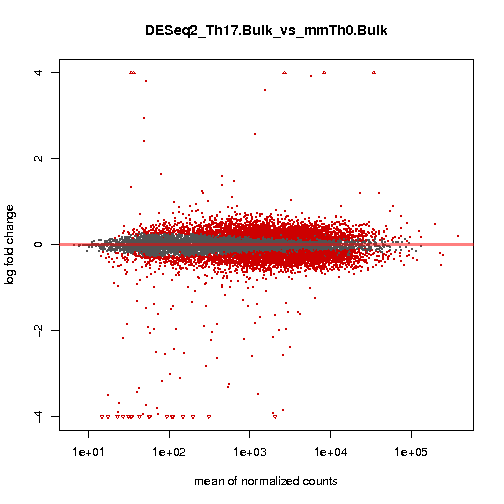

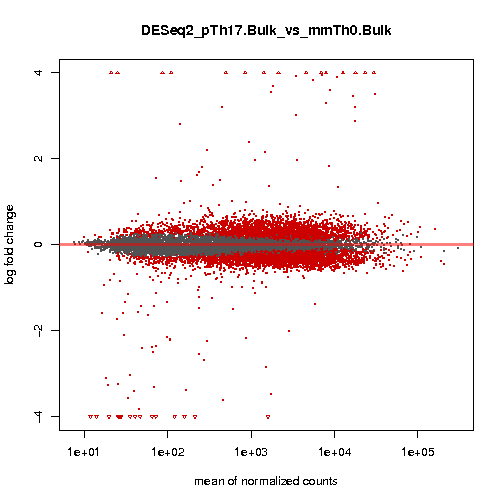

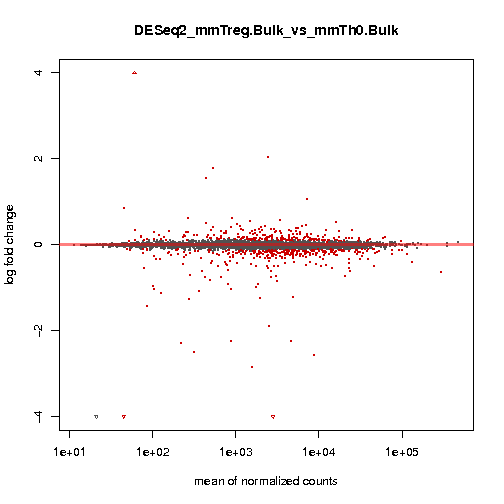

In [8]:
from IPython.display import display, Image
COMPARISONS=[
    "Th17.Bulk_vs_mmTh0.Bulk",
    "pTh17.Bulk_vs_mmTh0.Bulk",
    "mmTreg.Bulk_vs_mmTh0.Bulk"
    ]
for c in COMPARISONS:
    display(Image("/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/%s.png" % c))

Visualize PCA plots 

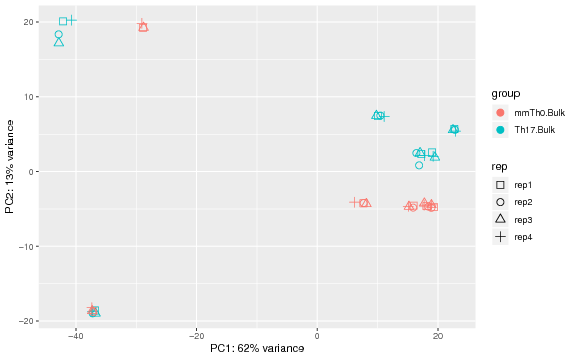

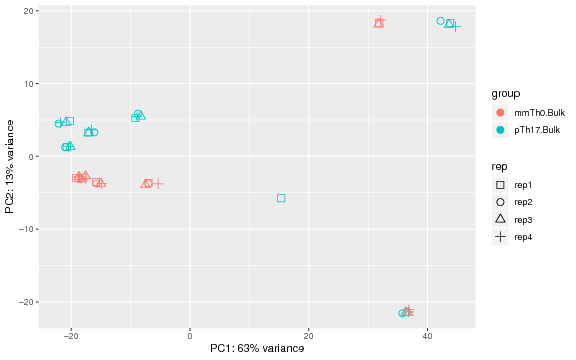

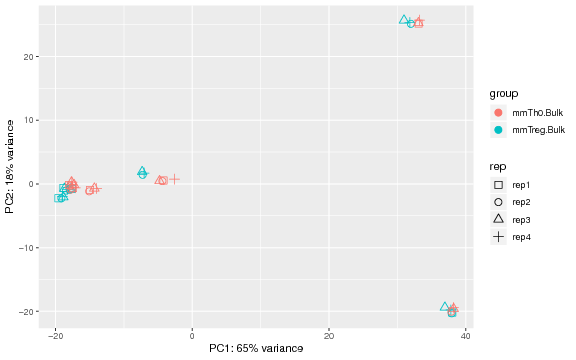

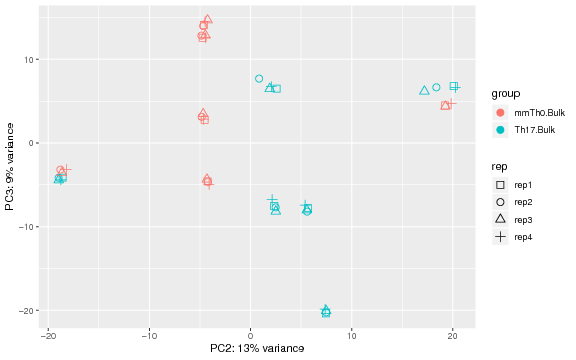

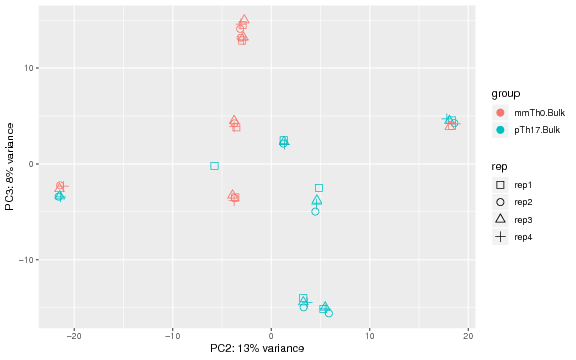

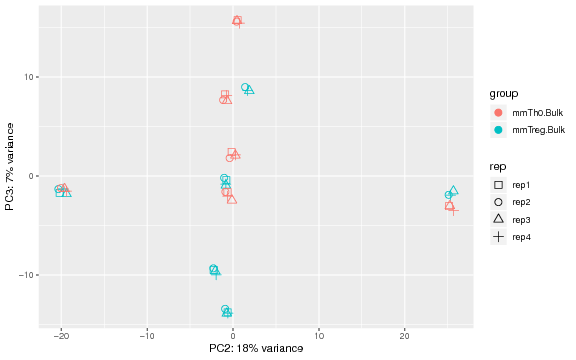

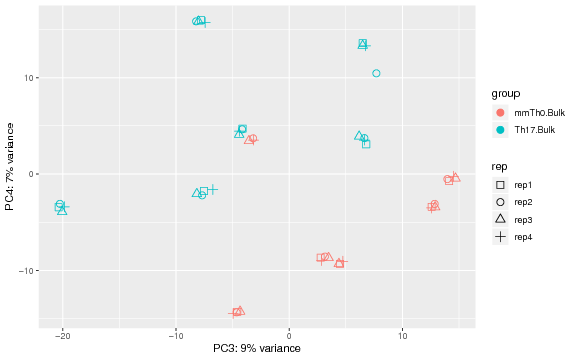

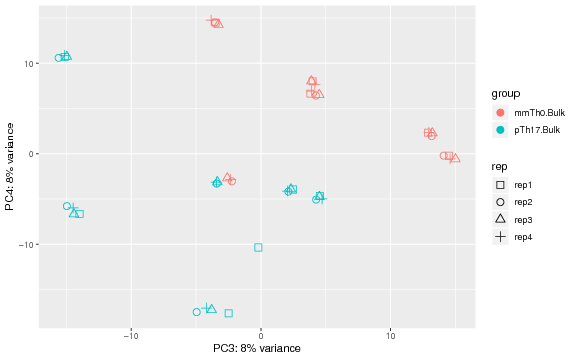

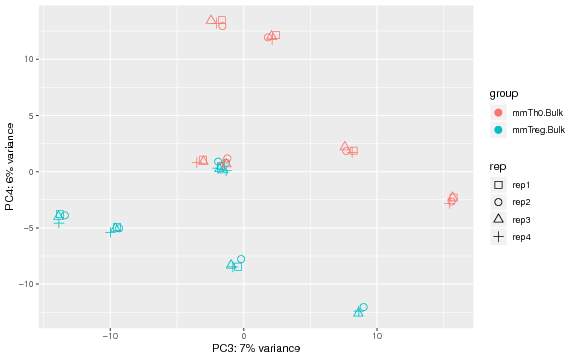

In [9]:
from IPython.display import display, Image
COMPARISONS=[
    "Th17.Bulk_vs_mmTh0.Bulk",
    "pTh17.Bulk_vs_mmTh0.Bulk",
    "mmTreg.Bulk_vs_mmTh0.Bulk"
    ]
PC = [
    'pca.1_vs_2',
    'pca.2_vs_3',
    'pca.3_vs_4'
]

for p in PC:
    for comp in COMPARISONS:
         display(Image("/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/%s.%s.png" % (comp, p)))

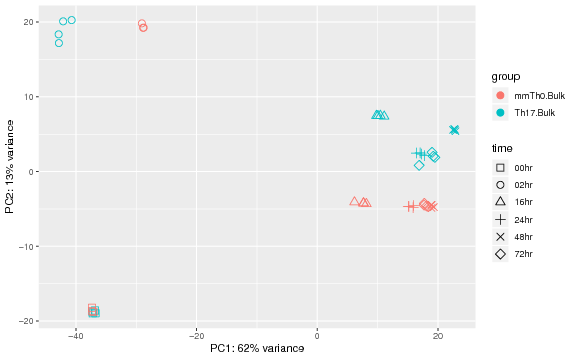

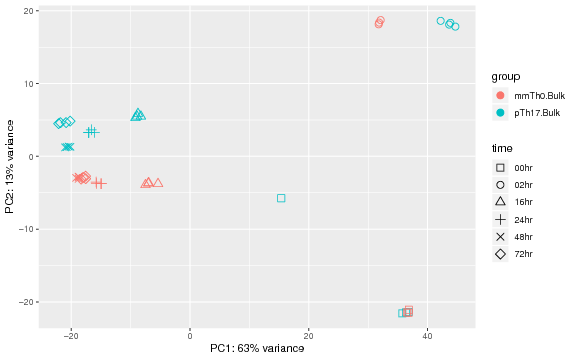

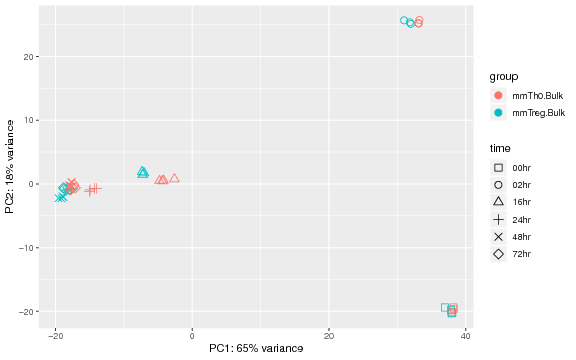

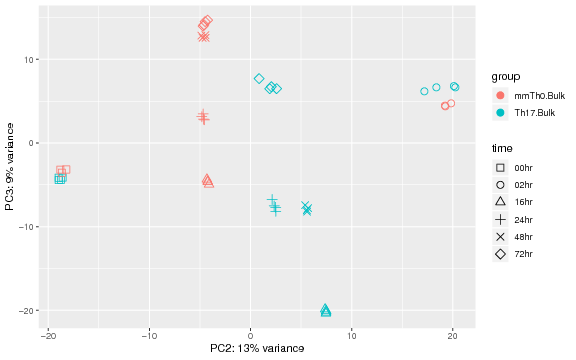

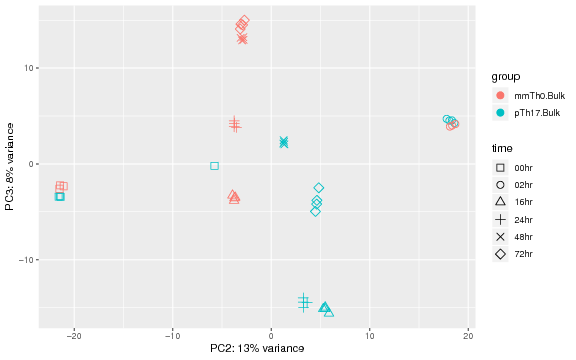

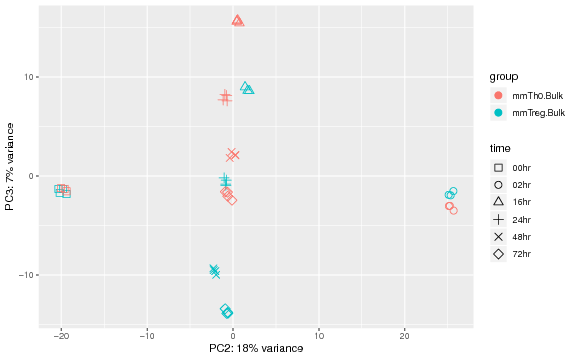

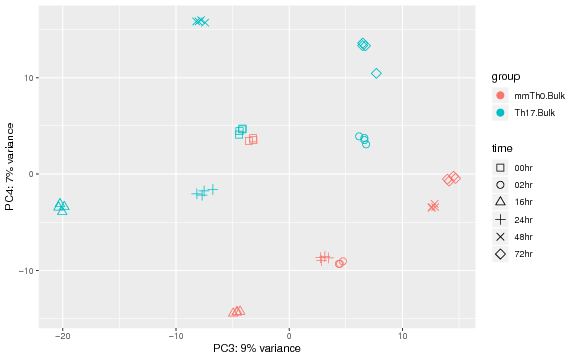

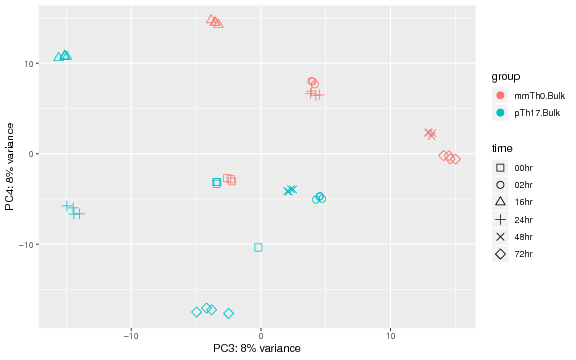

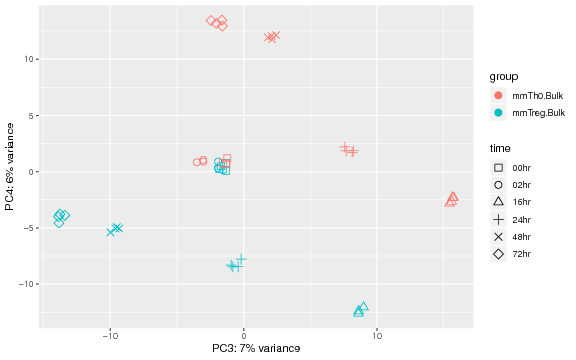

In [10]:
from IPython.display import display, Image
COMPARISONS=[
    "Th17.Bulk_vs_mmTh0.Bulk",
    "pTh17.Bulk_vs_mmTh0.Bulk",
    "mmTreg.Bulk_vs_mmTh0.Bulk"
    ]
PC = [
    'time.pca.1_vs_2',
    'time.pca.2_vs_3',
    'time.pca.3_vs_4'
]

for p in PC:
    for comp in COMPARISONS:
         display(Image("/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/%s.%s.png" % (comp, p)))

In [14]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/
for ii in $(/bin/ls -1 comp_*/*_vs_*.txt | /bin/grep -v with_genes);
do
    python /data/reddylab/Alex/collab/20180628_Layden/processing/rna_seq/scripts/mm10.rnaseq_dge_deseq2.add_gene_names.py \
        ${ii} \
        ${ii/.txt/.with_genes.txt}
done

/bin/ls: cannot access comp_*/*_vs_*.txt: No such file or directory


In [9]:
%matplotlib inline

In [3]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.01
top_to_report = 30
lfc_thres = 6.0
special_genes = ['Maf', 'Il17a', 'Rorc', 'Stat3', 'Stat5', 'Batf', 'Irf4', 'Runx1', 'Il21r', 'Tbx21', 'Foxp3']
comparisons = [
    "Th17.Bulk_vs_mmTh0.Bulk",
#    "pTh17.Bulk_vs_mmTh0.Bulk",
    "mmTreg.Bulk_vs_mmTh0.Bulk"  
]

data_dir = '/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2'

for comparison in comparisons:
    df = pd.read_csv("%s/%s.with_genes.txt" % (data_dir, comparison),
                    sep="\t")
#     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
#                     sep="\t",
#                     names=['GeneName', 'GeneType'])
#     df = df.merge(df_gene_name_type, on='GeneName')
#     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
#     df = df[~df.GeneType.isin(pseudogene_types)]
#     df = df[df.GeneType.isin(['protein_coding'])]
    fig = plt.figure(figsize=(12, 10))
    ax = plt.subplot(1, 1, 1)
    df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
    ax.set_xscale('log')
    ax.plot(df_non_sig['baseMean'].values, 
            df_non_sig['log2FoldChange'].values, 
            'o', color='darkgrey', label='non-sig. DEGs')

    ylims = [np.ceil(df['log2FoldChange'].min()-1), 
             np.floor(df['log2FoldChange'].max()+1)]
    df_sig = df[df.padj<=pval_thres]
    ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.6, label='sig. DEGs')

    # Annotate the top top_to_report
    df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)

#     if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
#         df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
#     ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', label='sig. DEGs')

#     for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
#         ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
#                     textcoords='offset points')

    # Annotate in particular IL1RN, HBG and EP300
    df_annotate_selected = df[df.GeneName.isin(special_genes)]
    ax.plot(df_annotate_selected['baseMean'].values, 
            df_annotate_selected['log2FoldChange'].values,color='blue', 
            marker='.', linestyle = 'None', alpha=1, label='interest genes')
    for x, y, t in zip(df_annotate_selected['baseMean'].values,
                       df_annotate_selected['log2FoldChange'].values, 
                       df_annotate_selected['GeneName'].values) :
        ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                textcoords='offset points')
    df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
    ax.plot(df_annotate_selected['baseMean'].values, 
            df_annotate_selected['log2FoldChange'].values,color='blue', 
            marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs')
    
    

    plt.ylim(ylims)
    plt.xlabel("mean of normalized counts")
    plt.ylabel("log2 fold-change")
    plt.title("%s\n%d genes diff. expressed (padj<=%.3f) - top %d annotated" % (comparison, 
                                                                                np.count_nonzero(df.padj<=pval_thres), 
                                                                                pval_thres, 
                                                                                top_to_report))
    plt.hlines(0, 0, 1e6, color='#ffcc80', linewidth =2 )
    plt.legend()

    # Remove spines and tight the layout
    simpleaxis(ax)
    plt.tight_layout()
    
#     # Save annotated MA plot
    plt.savefig("/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/degs.%s.with_genes.annotated_plot_MA.pdf" % comparison)
    
#     # Save annotated genes without pseudogenes
#     df_annotate.to_csv("/data/reddylab/Alex/collab/20180214_JoshBlack/results/rna_seq/degs%s.with_genes.sig_DE_no_pseudogenes.txt" % comparison,
#                       sep='\t',
#                       index=False)
    
#     # print table of values 
#     print ("======", comparison, "======")
#     display(df_annotate)
    
   


### Common DE genes in Th17 and pTh17

In [1]:
import pandas as pd

comparisons = [
    "Th17.Bulk_vs_mmTh0.Bulk",
    "pTh17.Bulk_vs_mmTh0.Bulk",
    #"mmTreg.Bulk_vs_mmTh0.Bulk"  
]

pval_thres = 0.01
data_dir = '/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2'
for comparison in comparisons:
    de_genes = pd.read_csv("%s/%s.with_genes.txt" % (data_dir, comparison), sep="\t")
    de_genes_sig = de_genes[de_genes.padj<=pval_thres]
de_genes

Unnamed: 0      baseMean  log2FoldChange     lfcSE  \
0      ENSMUSG00000024610.14   1593.696159       -4.449664  0.158218   
1       ENSMUSG00000030678.7  10579.479251       -0.511762  0.037502   
2      ENSMUSG00000060586.10    158.753440       -4.840191  0.355270   
3      ENSMUSG00000036594.14    121.294766       -5.028150  0.374109   
4       ENSMUSG00000073421.5    212.466679       -5.412869  0.432070   
...                      ...           ...             ...       ...   
12326   ENSMUSG00000092837.1    198.319670       -0.000278  0.246610   
12327   ENSMUSG00000085207.1     37.052713       -0.000229  0.237647   
12328  ENSMUSG00000026355.11  16302.117637       -0.000109  0.084487   
12329  ENSMUSG00000038544.14   1679.626916        0.000093  0.064478   
12330  ENSMUSG00000038240.13    478.374122       -0.000127  0.098779   

              pvalue           padj GeneName        GeneType  
0      2.286199e-174  2.819112e-170     Cd74  protein_coding  
1       2.811132e-43   1.733204e-39      Maz  protein_coding  
2       1.120980e-42   4.607603e-39   H2-Eb1  protein_coding  
3       1.262973e-41   3.893429e-38    H2-Aa  protein_coding  
4       1.605157e-36   3.958639e-33   H2-Ab1  protein_coding  
...              ...            ...      ...             ...  
12326   9.981164e-01   9.984403e-01    Rpph1        ribozyme  
12327   9.985420e-01   9.987850e-01  Gm11767       antisense  
12328   9.989198e-01   9.989198e-01     Mcm6  protein_coding  
12329   9.988110e-01   9.989198e-01     Inip  protein_coding  
12330   9.988971e-01   9.989198e-01    Pdss2  protein_coding  

[12331 rows x 8 columns]

In [2]:
import pandas as pd


df_Th17 = pd.read_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/Th17.Bulk_vs_mmTh0.Bulk.with_genes.txt', sep = '\t')
degene_Th17 = df_Th17[df_Th17.padj<=0.01]

df_pTh17 = pd.read_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/pTh17.Bulk_vs_mmTh0.Bulk.with_genes.txt', sep = '\t')
degene_pTh17 = df_pTh17[df_pTh17.padj<=0.01]

In [5]:
degene_Th17.to_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/Th17_DEgenes.csv')
degene_pTh17.to_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/pTh17_DEgenes.csv')


Creating a table of DE genes common in Th17 and pTh17

In [4]:
common_degene = degene_Th17.merge(degene_pTh17, how = 'inner', on = 'Unnamed: 0')
common_degene.to_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/Common_DEgenes.csv')

Unnamed: 0    baseMean_x  log2FoldChange_x   lfcSE_x  \
0     ENSMUSG00000024610.14   1968.007982         -3.906915  0.155990   
1     ENSMUSG00000026103.14  13746.065178          0.639667  0.039811   
2      ENSMUSG00000073421.5    308.575109         -4.796810  0.306865   
3     ENSMUSG00000036594.14    147.647263         -4.538107  0.300425   
4     ENSMUSG00000022791.16   5647.607124         -1.008920  0.086720   
...                     ...           ...               ...       ...   
3065   ENSMUSG00000032171.7   4027.205274         -0.190336  0.066797   
3066  ENSMUSG00000029670.12   1996.635515          0.218689  0.077879   
3067  ENSMUSG00000048921.11    438.463065         -0.299752  0.112930   
3068  ENSMUSG00000052752.15   7061.487773         -0.201872  0.071315   
3069  ENSMUSG00000039987.15   1741.397294          0.189944  0.066798   

           pvalue_x         padj_x GeneName_x      GeneType_x    baseMean_y  \
0     8.071722e-139  1.004526e-134       Cd74  protein_coding   1593.696159   
1      1.895637e-59   1.179560e-55        Gls  protein_coding  11717.098865   
2      1.238173e-55   5.136355e-52     H2-Ab1  protein_coding    212.466679   
3      4.700766e-52   1.462526e-48      H2-Aa  protein_coding    121.294766   
4      1.852834e-39   3.843087e-36       Tnk2  protein_coding   4672.201850   
...             ...            ...        ...             ...           ...   
3065   3.150730e-03   9.824814e-03       Pin1  protein_coding   3467.667422   
3066   3.193261e-03   9.947468e-03       Ing3  protein_coding   1561.608099   
3067   3.194077e-03   9.947520e-03     Zfp689  protein_coding    372.513808   
3068   3.195348e-03   9.948987e-03      Traf7  protein_coding   6097.601765   
3069   3.213845e-03   9.994603e-03      Phtf2  protein_coding   1397.329869   

      log2FoldChange_y   lfcSE_y       pvalue_y         padj_y GeneName_y  \
0            -4.449664  0.158218  2.286199e-174  2.819112e-170       Cd74   
1             0.705015  0.066290   1.909510e-28   1.962181e-25        Gls   
2            -5.412869  0.432070   1.605157e-36   3.958639e-33     H2-Ab1   
3            -5.028150  0.374109   1.262973e-41   3.893429e-38      H2-Aa   
4            -0.569176  0.093572   6.764412e-11   1.303312e-09       Tnk2   
...                ...       ...            ...            ...        ...   
3065         -0.238814  0.070331   4.381094e-04   1.571357e-03       Pin1   
3066          0.254123  0.065185   5.901763e-05   2.706383e-04       Ing3   
3067         -0.344914  0.106635   4.321862e-04   1.552371e-03     Zfp689   
3068         -0.252074  0.056368   4.824383e-06   2.901925e-05      Traf7   
3069          0.311391  0.071395   6.097526e-06   3.599262e-05      Phtf2   

          GeneType_y  
0     protein_coding  
1     protein_coding  
2     protein_coding  
3     protein_coding  
4     protein_coding  
...              ...  
3065  protein_coding  
3066  protein_coding  
3067  protein_coding  
3068  protein_coding  
3069  protein_coding  

[3070 rows x 15 columns]

### DE analysis for Th0 cells taking 00hr as the control and other timestamps as treatment samples

Data manipulation for DESeq analysis

In [18]:
import glob
import re
import pandas as pd

comp_files = {
    'mmTh0.Bulk.02hr': [
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.02h.rep1.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.02h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.02h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep4.star2.featurecounts.counts.txt'
    ],
    
    'mmTh0.Bulk.16hr': [
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.16h.rep1.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.16h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.16h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.16h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep4.star2.featurecounts.counts.txt'
    ],
    
    'mmTh0.Bulk.24hr': [
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.24h.rep1.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.24h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.24h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.24h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep4.star2.featurecounts.counts.txt'
    ],
    
    'mmTh0.Bulk.48hr': [
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.48h.rep1.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.48h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.48h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.48h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep4.star2.featurecounts.counts.txt'
    ],
    
    'mmTh0.Bulk.72hr': [
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated_bulk.72h.rep1.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated_bulk.72h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated_bulk.72h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated_bulk.72h.rep4.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep2.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep3.star2.featurecounts.counts.txt',
    '/data/reddylab/Alex/encode4_duke/processing/rna_seq/Siklenka_5596_190418A6-pe-revstranded-with-sjdb/mmTh0.rna_seq.activated.00h.rep4.star2.featurecounts.counts.txt'
    ]
    
}

def clean_count_column(s):
    items = ['bulk', 'Bulk']
    name = '.'.join(s.split('/')[-1].split('.')[:3])
    if name.startswith('mm'):
        if any(i in s for i in items):
            return '.'.join(s.split('/')[-1].replace('.rna_seq.activated_bulk','.Bulk').replace('h.','hr.').split('.')[:4])
        else:
            return '.'.join(s.split('/')[-1].replace('.rna_seq.activated','.Bulk').replace('h.','hr.').split('.')[:4])
        
    else:
        if any(i in s for i in items):
            split_words = '.'.join(s.split('.')[1:3])
            rev_words = '.'.join(list(reversed(s.split('.')[1:3])))
            return '.'.join(s.split('/')[-1].replace(split_words, rev_words).split('.')[:4])
        else:
            s = re.sub('17.', '17.Bulk.', s)
            return '.'.join(s.split('/')[-1].split('.')[:4])
        
        
for comp, files in comp_files.items():
    df = None
    for f in files:
        df_tmp = pd.read_csv(f, sep='\t', skiprows=1, index_col=0)
        df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_count_column(f)]
        if df is None:
            df = df_tmp.loc[:, ['Chr', 'Start', 'End'] + [df_tmp.columns[-1]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-1]], how='right')

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='int')

    df.to_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/%s.counts.txt' % comp, sep='\t')

DEseq analysis

In [15]:
%%bash
mkdir -p /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/mmTh0
source /data/reddylab/software/miniconda3/bin/activate alex_py3
sbatch -pnew,all \
    --array=0-1 \
    --mem 16G \
    -o /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/mmTh0.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
     mmTh0.Bulk.02hr-mmTh0.Bulk.00hr \
     mmTh0.Bulk.16hr-mmTh0.Bulk.00hr \ 
     mmTh0.Bulk.24hr-mmTh0.Bulk.00hr \
     mmTh0.Bulk.48hr-mmTh0.Bulk.00hr \
     mmTh0.Bulk.72hr-mmTh0.Bulk.00hr \
)
COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
CONTROL=$(echo $COMPARISON | cut -d"-" -f2)
FACTOR=$(echo $COMPARISON | cut -d"-" -f1)
Rscript /data/reddylab/Revathy/dev/scripts/rnaseq_dge.deseq2_v2.R \
    --treatments $(echo mmTh0.Bulk.02hr.rep{1,3,4}) $(echo mmTh0.Bulk.{16,24,48,72}hr.rep{1,2,3,4})\
    --controls $(echo ${CONTROL}.rep{2,3,4}) \
    --lfcShrink ashr \
    --counts-skip-ncols 3 \
    --outdir /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/mmTh0 \
    --counts /data/reddylab/Revathy/dev/rna-seq_Siklenka/${FACTOR}.counts.txt
    
EOF


Submitted batch job 23204575


Create list of upregulated and downregulated genes

In [ ]:
%%bash
FDR=0.05
COMPARISONS=( \ 
     mmTh0.Bulk.02hr_vs_mmTh0.Bulk.00hr \
     mmTh0.Bulk.16hr_vs_mmTh0.Bulk.00hr \
     mmTh0.Bulk.24hr_vs_mmTh0.Bulk.00hr \ 
     mmTh0.Bulk.48hr_vs_mmTh0.Bulk.00hr \
     mmTh0.Bulk.72hr_vs_mmTh0.Bulk.00hr
)
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/mmTh0
for COMP in ${COMPARISONS[@]};
do
    # Save expressed genes (more than 5 normalized counts)
    tail -n+2 ${COMP}.txt |  cut -d. -f1 > ${COMP}.expressed_genes.txt 
    
    # Save significant upreg genes
    tail -n+2 ${COMP}.txt |  awk -vFDR=${FDR} '{if(($NF<FDR) && ($3>0)){print $1}}' |  cut -d. -f1 > ${COMP}.upreg_genes.txt 

    # Save significant downreg genes
    tail -n+2 ${COMP}.txt |  awk -vFDR=${FDR} '{if(($NF<FDR) && ($3<0)){print $1}}' |  cut -d. -f1 > ${COMP}.downreg_genes.txt 

done

In [18]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/mmTh0
for ii in $(/bin/ls -1 *_vs_*hr.txt | /bin/grep -v with_genes);
do
    python /data/reddylab/Alex/collab/20180628_Layden/processing/rna_seq/scripts/mm10.rnaseq_dge_deseq2.add_gene_names.py \
        ${ii} \
        ${ii/.txt/.with_genes.txt}
done

In [19]:
%%bash
FDR=0.05
COMPARISONS=( \
     mmTh0.Bulk.02hr_vs_mmTh0.Bulk.00hr \
     mmTh0.Bulk.16hr_vs_mmTh0.Bulk.00hr \
     mmTh0.Bulk.24hr_vs_mmTh0.Bulk.00hr \ 
     mmTh0.Bulk.48hr_vs_mmTh0.Bulk.00hr \
     mmTh0.Bulk.72hr_vs_mmTh0.Bulk.00hr
)
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/mmTh0
for COMP in ${COMPARISONS[@]};
do
    # Save expressed genes (more than 5 normalized counts)
    tail -n+2 ${COMP}.with_genes.txt |  awk '{print $NF}' > ${COMP}.expressed_genes.symbols.txt 

    # Save significant upreg genes
    tail -n+2 ${COMP}.with_genes.txt |  awk -vFDR=${FDR} '{if(($(NF-1)<FDR) && ($3>0)){print $NF}}' > ${COMP}.upreg_genes.symbols.txt 

    # Save significant downreg genes
    tail -n+2 ${COMP}.with_genes.txt |  awk -vFDR=${FDR} '{if(($(NF-1)<FDR) && ($3<0)){print $NF}}' > ${COMP}.downreg_genes.symbols.txt 

done

Convert .pdf to .png

In [20]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/mmTh0
module load ImageMagick/7.0.1-gcb01
for ii in $(/bin/ls -1 *.pdf);
do
    convert ${ii} ${ii/.pdf/.png}
done

Display the PCA plots

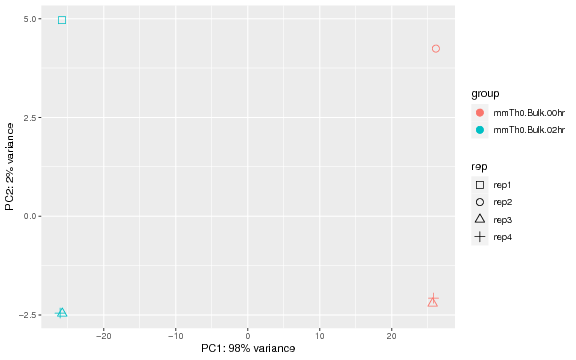

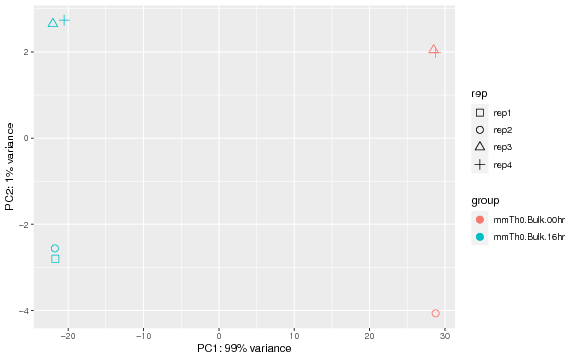

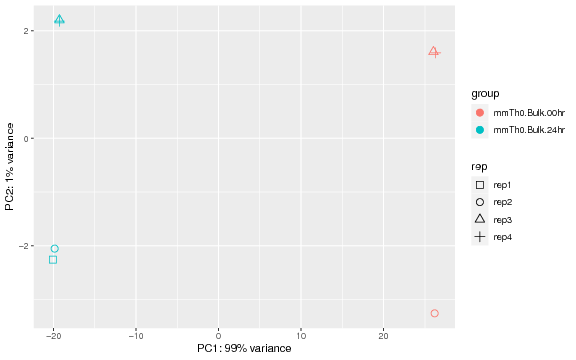

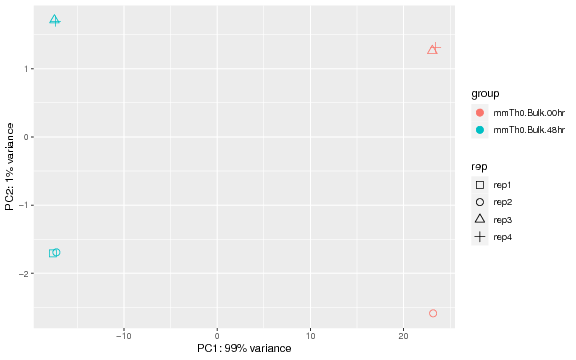

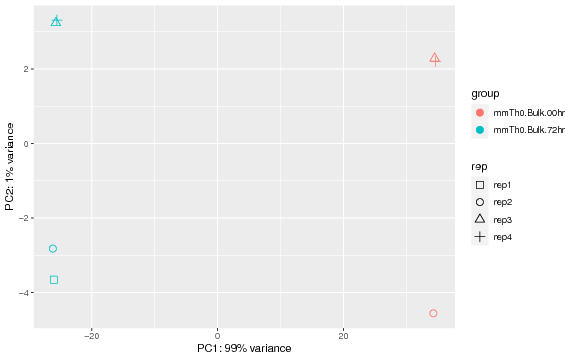

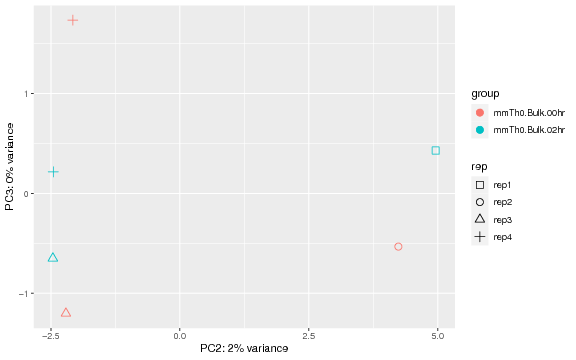

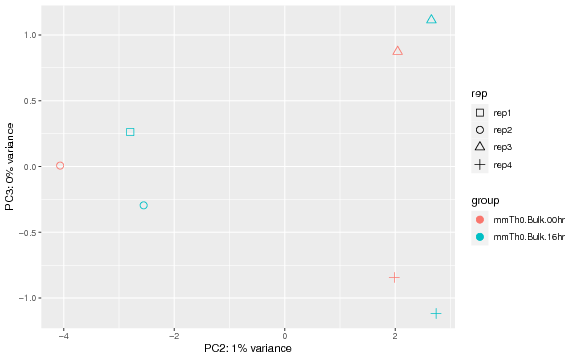

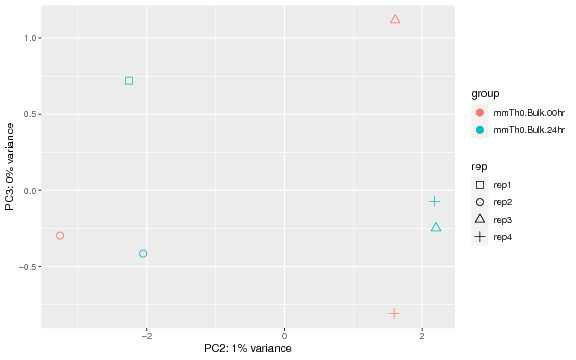

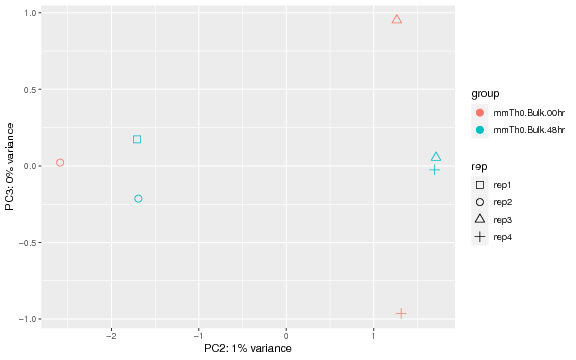

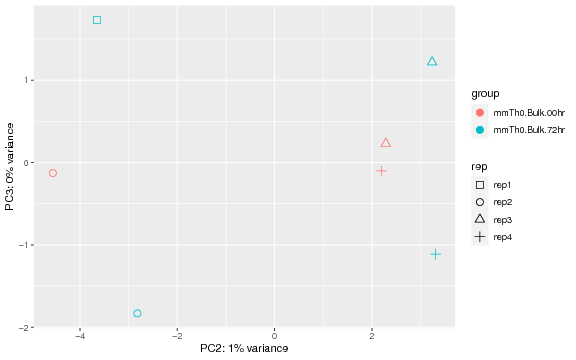

In [21]:
from IPython.display import display, Image
COMPARISONS=[
     'mmTh0.Bulk.02hr_vs_mmTh0.Bulk.00hr',
     'mmTh0.Bulk.16hr_vs_mmTh0.Bulk.00hr', 
     'mmTh0.Bulk.24hr_vs_mmTh0.Bulk.00hr', 
     'mmTh0.Bulk.48hr_vs_mmTh0.Bulk.00hr',
     'mmTh0.Bulk.72hr_vs_mmTh0.Bulk.00hr'
    ]
PC = [
    'pca.1_vs_2',
    'pca.2_vs_3'
]

for p in PC:
    for comp in COMPARISONS:
         display(Image("/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/mmTh0/%s.%s.png" % (comp, p)))
            

Display top30 DE genes and MA plots with 

====== mmTh0.Bulk.02hr_vs_mmTh0.Bulk.00hr ======


Unnamed: 0       baseMean  log2FoldChange     lfcSE  pvalue  \
0   ENSMUSG00000026107.11   20047.642897        3.596992  0.073146     0.0   
94   ENSMUSG00000033730.3   29391.862268        5.870248  0.075044     0.0   
93   ENSMUSG00000037580.9    5179.268003        5.182781  0.109395     0.0   
92   ENSMUSG00000048376.5    5627.771050        4.156462  0.109445     0.0   
91  ENSMUSG00000007617.17    6402.878932        4.459169  0.096063     0.0   
90  ENSMUSG00000052087.13    6133.922428       -4.023680  0.095173     0.0   
89  ENSMUSG00000038518.15   19053.531160        2.897135  0.071474     0.0   
88   ENSMUSG00000051335.5   14176.796118        6.598809  0.104474     0.0   
87  ENSMUSG00000036006.19   18622.661891       -2.940435  0.071304     0.0   
86   ENSMUSG00000076617.9   15141.329314       -3.345793  0.083976     0.0   
85   ENSMUSG00000021127.7   65361.426832        3.317380  0.064527     0.0   
84   ENSMUSG00000011179.7   47136.366049        6.305434  0.075461     0.0   
83  ENSMUSG00000017493.12   26745.155622       -2.838144  0.068220     0.0   
82  ENSMUSG00000020859.16   29405.689101        3.770491  0.070602     0.0   
95   ENSMUSG00000022015.8    8995.270454        6.743541  0.121014     0.0   
81   ENSMUSG00000020846.6    7036.663833       -3.545079  0.087251     0.0   
79  ENSMUSG00000020893.17   25055.192043        3.783421  0.073227     0.0   
78  ENSMUSG00000020901.13   10656.246375       -3.437213  0.080336     0.0   
77   ENSMUSG00000018932.9   24012.228534        4.836627  0.073331     0.0   
76  ENSMUSG00000020534.14    3905.026146        4.469437  0.111810     0.0   
75  ENSMUSG00000002699.13   67554.101079        2.930514  0.064422     0.0   
74   ENSMUSG00000020275.9   38894.396837        4.604853  0.069745     0.0   
73   ENSMUSG00000041046.7   28260.175656        6.640530  0.082800     0.0   
72  ENSMUSG00000025402.12   35631.862610        3.749273  0.076397     0.0   
71   ENSMUSG00000052302.6    8436.424787        3.512202  0.084662     0.0   
70  ENSMUSG00000020015.10   25890.646233        3.105761  0.068876     0.0   
69  ENSMUSG00000061589.14   49322.314465        3.256445  0.072712     0.0   
68  ENSMUSG00000035640.18    9090.876694        3.543760  0.084792     0.0   
67  ENSMUSG00000037868.15   23734.842962        5.810446  0.077811     0.0   
80   ENSMUSG00000018476.7  122017.317522        4.297140  0.063715     0.0   

    padj GeneName        GeneType  
0    0.0    Nabp1  protein_coding  
94   0.0     Egr3  protein_coding  
93   0.0     Gch1  protein_coding  
92   0.0      F2r  protein_coding  
91   0.0   Homer1  protein_coding  
90   0.0    Rgs14  protein_coding  
89   0.0   Jarid2  protein_coding  
88   0.0    Gfod1  protein_coding  
87   0.0   Fam65b  protein_coding  
86   0.0     Ighm       IG_C_gene  
85   0.0  Zfp36l1  protein_coding  
84   0.0     Odc1  protein_coding  
83   0.0   Igfbp4  protein_coding  
82   0.0    Spag9  protein_coding  
95   0.0  Tnfsf11  protein_coding  
81   0.0    Rflnb  protein_coding  
79   0.0     Per1  protein_coding  
78   0.0   Pik3r5  protein_coding  
77   0.0   Map2k3  protein_coding  
76   0.0    Shmt1  protein_coding  
75   0.0     Lcp2  protein_coding  
74   0.0      Rel  protein_coding  
73   0.0    Ramp3  protein_coding  
72   0.0     Nab2  protein_coding  
71   0.0  Tbc1d30  protein_coding  
70   0.0    Cdk17  protein_coding  
69   0.0    Dot1l  protein_coding  
68   0.0    Cbarp  protein_coding  
67   0.0     Egr2  protein_coding  
80   0.0    Kdm6b  protein_coding

====== mmTh0.Bulk.16hr_vs_mmTh0.Bulk.00hr ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE  pvalue  \
0    ENSMUSG00000041859.10  27844.046966        3.817670  0.071331     0.0   
249   ENSMUSG00000020766.4   5638.252044        3.565114  0.081110     0.0   
248  ENSMUSG00000034586.14   2541.831835       -3.927273  0.089753     0.0   
247  ENSMUSG00000020732.13   1962.251632       -4.255729  0.108697     0.0   
246  ENSMUSG00000020717.19   6190.336244       -3.911810  0.070744     0.0   
245   ENSMUSG00000020689.4   5730.659129       -4.596244  0.078679     0.0   
244   ENSMUSG00000018677.9   7518.009523        2.546998  0.060804     0.0   
243   ENSMUSG00000078652.9  20991.456100        2.255827  0.051594     0.0   
242  ENSMUSG00000006782.16   7384.325429       -3.683456  0.062854     0.0   
241  ENSMUSG00000017493.12  24970.226497       -3.938986  0.057578     0.0   
240  ENSMUSG00000017499.15   2800.885838        6.683659  0.168508     0.0   
239   ENSMUSG00000001440.5  47186.104286        1.828350  0.045605     0.0   
238  ENSMUSG00000057058.16   6928.620874       -2.782772  0.064670     0.0   
237   ENSMUSG00000020869.8  11150.714785        2.637500  0.062808     0.0   
236  ENSMUSG00000018428.15   2569.307213        3.746584  0.095918     0.0   
235   ENSMUSG00000078763.2   5846.500015       -3.587567  0.065819     0.0   
234  ENSMUSG00000035208.16   4195.625995       -3.408288  0.074793     0.0   
233   ENSMUSG00000020841.5   5414.179454        7.540538  0.153938     0.0   
232   ENSMUSG00000020846.6   7085.840557       -3.662357  0.068656     0.0   
231  ENSMUSG00000020741.17  20455.541836        2.411541  0.050590     0.0   
250  ENSMUSG00000025572.17  11073.687653       -2.423804  0.057160     0.0   
230  ENSMUSG00000040463.16  58228.083901        2.489165  0.047163     0.0   
251   ENSMUSG00000053113.3   3944.586972       -5.379236  0.111820     0.0   
253  ENSMUSG00000070327.14  30269.432413       -4.037234  0.082665     0.0   
272  ENSMUSG00000002325.14   4950.626185       -2.992271  0.071928     0.0   
271   ENSMUSG00000021957.6  26140.140227        2.104277  0.053831     0.0   
270   ENSMUSG00000017756.8  12557.651645       -3.058161  0.067311     0.0   
269  ENSMUSG00000021595.18  23924.111929        2.418639  0.050380     0.0   
268  ENSMUSG00000052087.13   6456.539869       -3.326830  0.066338     0.0   
267  ENSMUSG00000025869.11   4943.743624        3.056465  0.070847     0.0   

     padj  GeneName        GeneType  
0     0.0      Mcm3  protein_coding  
249   0.0     Galk1  protein_coding  
248   0.0      Hid1  protein_coding  
247   0.0     Rab37  protein_coding  
246   0.0    Pecam1  protein_coding  
245   0.0     Itgb3  protein_coding  
244   0.0  Slc25a39  protein_coding  
243   0.0     Psme3  protein_coding  
242   0.0       Cnp  protein_coding  
241   0.0    Igfbp4  protein_coding  
240   0.0      Cdc6  protein_coding  
239   0.0     Kpnb1  protein_coding  
238   0.0     Skap1  protein_coding  
237   0.0    Lrrc59  protein_coding  
236   0.0     Akap1  protein_coding  
235   0.0     Slfn1  protein_coding  
234   0.0     Slfn8  protein_coding  
233   0.0       Cpd  protein_coding  
232   0.0     Rflnb  protein_coding  
231   0.0      Cluh  protein_coding  
250   0.0      Tmc6  protein_coding  
230   0.0   Mybbp1a  protein_coding  
251   0.0     Socs3  protein_coding  
253   0.0    Rnf213  protein_coding  
272   0.0      Irf9  protein_coding  
271   0.0       Tkt  protein_coding  
270   0.0   Slc12a7  protein_coding  
269   0.0     Nsun2  protein_coding  
268   0.0     Rgs14  protein_coding  
267   0.0     Nop16  protein_coding

====== mmTh0.Bulk.24hr_vs_mmTh0.Bulk.00hr ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE  pvalue  \
0    ENSMUSG00000041859.10  31652.829266        3.652618  0.051346     0.0   
414   ENSMUSG00000078652.9  24681.105112        2.099289  0.040857     0.0   
415  ENSMUSG00000017146.12   3517.597258        4.578558  0.109622     0.0   
416  ENSMUSG00000020929.14  22121.928919        1.835154  0.041387     0.0   
417  ENSMUSG00000055805.15  39635.326246       -1.776651  0.042118     0.0   
418   ENSMUSG00000020689.4   7445.540692       -4.273556  0.060090     0.0   
419  ENSMUSG00000020717.19   7992.896303       -3.790728  0.091071     0.0   
420  ENSMUSG00000018362.14   6278.799773        3.908113  0.073661     0.0   
421  ENSMUSG00000040430.18   8304.018077       -2.371568  0.060202     0.0   
422  ENSMUSG00000020732.13   2561.257472       -3.934179  0.086708     0.0   
423  ENSMUSG00000020739.11  12058.623366        1.998165  0.048410     0.0   
424   ENSMUSG00000020766.4   5837.334899        3.249836  0.077002     0.0   
425  ENSMUSG00000025572.17  14083.921017       -2.446070  0.060447     0.0   
426  ENSMUSG00000025574.13   6083.621429        7.355762  0.151977     0.0   
427  ENSMUSG00000017716.15   3833.181857        6.255565  0.159010     0.0   
428   ENSMUSG00000053113.3   5041.121117       -5.747316  0.104809     0.0   
413  ENSMUSG00000017802.14   9886.884502       -1.849533  0.047737     0.0   
412  ENSMUSG00000006782.16   9875.625727       -3.138920  0.054668     0.0   
411  ENSMUSG00000017493.12  32005.119904       -4.011700  0.040950     0.0   
410  ENSMUSG00000020914.17  30893.133936        6.496671  0.080966     0.0   
394   ENSMUSG00000018446.8  14466.765316        2.702954  0.050116     0.0   
395  ENSMUSG00000040463.16  63045.718534        2.221584  0.049170     0.0   
396  ENSMUSG00000020741.17  21538.179770        2.105134  0.049361     0.0   
397   ENSMUSG00000020846.6   9161.442325       -3.569437  0.060423     0.0   
398   ENSMUSG00000020841.5  10701.554113        8.155537  0.145270     0.0   
399   ENSMUSG00000002055.9   3371.170267        6.468513  0.162836     0.0   
400  ENSMUSG00000035208.16   5286.623543       -3.692317  0.074647     0.0   
429  ENSMUSG00000017132.17  12470.688853       -2.440114  0.045421     0.0   
401   ENSMUSG00000078763.2   7183.632802       -4.385584  0.059534     0.0   
403  ENSMUSG00000018428.15   3010.796433        3.630966  0.092479     0.0   

     padj GeneName        GeneType  
0     0.0     Mcm3  protein_coding  
414   0.0    Psme3  protein_coding  
415   0.0    Brca1  protein_coding  
416   0.0   Eftud2  protein_coding  
417   0.0    Fmnl1  protein_coding  
418   0.0    Itgb3  protein_coding  
419   0.0   Pecam1  protein_coding  
420   0.0    Kpna2  protein_coding  
421   0.0  Pitpnc1  protein_coding  
422   0.0    Rab37  protein_coding  
423   0.0    Nup85  protein_coding  
424   0.0    Galk1  protein_coding  
425   0.0     Tmc6  protein_coding  
426   0.0      Tk1  protein_coding  
427   0.0    Birc5  protein_coding  
428   0.0    Socs3  protein_coding  
413   0.0  Fam134c  protein_coding  
412   0.0      Cnp  protein_coding  
411   0.0   Igfbp4  protein_coding  
410   0.0    Top2a  protein_coding  
394   0.0    C1qbp  protein_coding  
395   0.0  Mybbp1a  protein_coding  
396   0.0     Cluh  protein_coding  
397   0.0    Rflnb  protein_coding  
398   0.0      Cpd  protein_coding  
399   0.0    Spag5  protein_coding  
400   0.0    Slfn8  protein_coding  
429   0.0    Cyth1  protein_coding  
401   0.0    Slfn1  protein_coding  
403   0.0    Akap1  protein_coding

====== mmTh0.Bulk.48hr_vs_mmTh0.Bulk.00hr ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE  pvalue  \
0    ENSMUSG00000041859.10  20878.302406        3.091245  0.052356     0.0   
426   ENSMUSG00000078652.9  17180.065677        1.617602  0.038685     0.0   
427  ENSMUSG00000017146.12   2589.487267        4.243106  0.111220     0.0   
428  ENSMUSG00000020929.14  17796.359646        1.567782  0.037786     0.0   
429  ENSMUSG00000055805.15  37921.271818       -1.631215  0.041885     0.0   
430   ENSMUSG00000020689.4   7350.960887       -3.324430  0.088130     0.0   
431  ENSMUSG00000040699.13  41777.623422       -2.037047  0.037499     0.0   
432  ENSMUSG00000020717.19   7603.824534       -3.492051  0.060874     0.0   
425  ENSMUSG00000017802.14   9181.647077       -1.880903  0.049501     0.0   
433  ENSMUSG00000020719.14  80149.802947       -1.204031  0.028880     0.0   
435  ENSMUSG00000040430.18   7682.500147       -2.411096  0.058591     0.0   
436   ENSMUSG00000020733.3  11164.185777       -1.982059  0.044166     0.0   
437  ENSMUSG00000034586.14   2888.822447       -5.466669  0.105362     0.0   
438   ENSMUSG00000020766.4   4427.576903        2.923502  0.077534     0.0   
439   ENSMUSG00000054517.9   2845.726289       -3.737140  0.086560     0.0   
440  ENSMUSG00000059248.13  18462.943532       -1.460835  0.038228     0.0   
441  ENSMUSG00000025571.13   8710.846615       -2.580681  0.051895     0.0   
434  ENSMUSG00000018362.14   6041.617383        3.958149  0.070111     0.0   
442  ENSMUSG00000025572.17  14764.175569       -1.772292  0.046339     0.0   
424  ENSMUSG00000006782.16   9636.511857       -2.708899  0.050822     0.0   
422  ENSMUSG00000020914.17  25149.824949        6.330030  0.084707     0.0   
406  ENSMUSG00000020849.13  20225.752467        1.872883  0.047660     0.0   
407   ENSMUSG00000020846.6   8027.863190       -4.789019  0.070067     0.0   
408   ENSMUSG00000020841.5   6145.438842        7.498094  0.152610     0.0   
409  ENSMUSG00000037926.15  16047.031838       -2.514465  0.043035     0.0   
410   ENSMUSG00000002055.9   4493.784655        6.966623  0.160441     0.0   
411  ENSMUSG00000035208.16   4827.795124       -4.040448  0.069194     0.0   
412   ENSMUSG00000078763.2   6653.947405       -4.557980  0.067970     0.0   
423  ENSMUSG00000017493.12  28128.095519       -5.941726  0.074803     0.0   
413   ENSMUSG00000000982.5   5265.216539        8.654986  0.218063     0.0   

     padj  GeneName        GeneType  
0     0.0      Mcm3  protein_coding  
426   0.0     Psme3  protein_coding  
427   0.0     Brca1  protein_coding  
428   0.0    Eftud2  protein_coding  
429   0.0     Fmnl1  protein_coding  
430   0.0     Itgb3  protein_coding  
431   0.0     Limd2  protein_coding  
432   0.0    Pecam1  protein_coding  
425   0.0   Fam134c  protein_coding  
433   0.0      Ddx5  protein_coding  
435   0.0   Pitpnc1  protein_coding  
436   0.0  Slc9a3r1  protein_coding  
437   0.0      Hid1  protein_coding  
438   0.0     Galk1  protein_coding  
439   0.0    Trim65  protein_coding  
440   0.0     Sept9  protein_coding  
441   0.0    Tnrc6c  protein_coding  
434   0.0     Kpna2  protein_coding  
442   0.0      Tmc6  protein_coding  
424   0.0       Cnp  protein_coding  
422   0.0     Top2a  protein_coding  
406   0.0     Ywhae  protein_coding  
407   0.0     Rflnb  protein_coding  
408   0.0       Cpd  protein_coding  
409   0.0      Ssh2  protein_coding  
410   0.0     Spag5  protein_coding  
411   0.0     Slfn8  protein_coding  
412   0.0     Slfn1  protein_coding  
423   0.0    Igfbp4  protein_coding  
413   0.0      Ccl3  protein_coding

====== mmTh0.Bulk.72hr_vs_mmTh0.Bulk.00hr ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE  pvalue  \
0    ENSMUSG00000041859.10  17287.771341        2.794427  0.073248     0.0   
167   ENSMUSG00000020846.6   7892.788295       -6.012490  0.089818     0.0   
168   ENSMUSG00000020841.5   7581.965283        7.759911  0.167719     0.0   
169  ENSMUSG00000035208.16   4872.118858       -4.112137  0.093290     0.0   
170   ENSMUSG00000078763.2   6852.800055       -3.990055  0.080504     0.0   
171  ENSMUSG00000020868.15   5003.363421       -2.982016  0.078673     0.0   
172   ENSMUSG00000075595.9   5116.738955       -4.558555  0.089842     0.0   
173  ENSMUSG00000038352.15   2759.607186       -4.721290  0.119660     0.0   
174   ENSMUSG00000018168.8   4550.564956       -6.593816  0.127864     0.0   
175  ENSMUSG00000020914.17  23831.931675        6.200258  0.117520     0.0   
176  ENSMUSG00000017493.12  28105.287422       -6.750428  0.100567     0.0   
177  ENSMUSG00000020717.19   8041.837094       -2.948089  0.067484     0.0   
178  ENSMUSG00000020732.13   2358.867474       -4.493623  0.104463     0.0   
179  ENSMUSG00000034586.14   2881.840004       -5.988053  0.145122     0.0   
180  ENSMUSG00000025574.13   3916.509143        6.739155  0.158809     0.0   
181   ENSMUSG00000053113.3   4738.105406       -5.822582  0.112646     0.0   
182   ENSMUSG00000039989.7   5356.729326       -3.133923  0.080087     0.0   
183  ENSMUSG00000025161.16   6222.304039        6.375691  0.133609     0.0   
184   ENSMUSG00000020601.7  10311.319760       -5.654970  0.101911     0.0   
185   ENSMUSG00000011179.7  47723.559795        5.618321  0.060760     0.0   
186  ENSMUSG00000020649.11  11319.570602        6.326844  0.128211     0.0   
187  ENSMUSG00000048251.15  19390.947865       -2.748851  0.065536     0.0   
188  ENSMUSG00000021285.14   5554.203058       -3.072976  0.081176     0.0   
189   ENSMUSG00000042029.6   5737.723757        6.217924  0.163561     0.0   
190  ENSMUSG00000016756.16   7792.355574       -3.404957  0.069694     0.0   
191  ENSMUSG00000036006.19  20313.697054       -5.009637  0.069335     0.0   
192   ENSMUSG00000021356.9  25967.778077        5.672348  0.126494     0.0   
193  ENSMUSG00000039114.15  19040.925176        8.315490  0.141843     0.0   
194   ENSMUSG00000051335.5   7028.181694        4.724511  0.115176     0.0   
195   ENSMUSG00000015396.3   6021.329359        6.580173  0.135119     0.0   

     padj  GeneName        GeneType  
0     0.0      Mcm3  protein_coding  
167   0.0     Rflnb  protein_coding  
168   0.0       Cpd  protein_coding  
169   0.0     Slfn8  protein_coding  
170   0.0     Slfn1  protein_coding  
171   0.0     Xylt2  protein_coding  
172   0.0    Zfp652  protein_coding  
173   0.0     Arl5c  protein_coding  
174   0.0     Ikzf3  protein_coding  
175   0.0     Top2a  protein_coding  
176   0.0    Igfbp4  protein_coding  
177   0.0    Pecam1  protein_coding  
178   0.0     Rab37  protein_coding  
179   0.0      Hid1  protein_coding  
180   0.0       Tk1  protein_coding  
181   0.0     Socs3  protein_coding  
182   0.0      Cbx4  protein_coding  
183   0.0   Slc16a3  protein_coding  
184   0.0     Trib2  protein_coding  
185   0.0      Odc1  protein_coding  
186   0.0      Rrm2  protein_coding  
187   0.0    Bcl11b  protein_coding  
188   0.0  Ppp1r13b  protein_coding  
189   0.0    Ncapg2  protein_coding  
190   0.0      Cmah  protein_coding  
191   0.0    Fam65b  protein_coding  
192   0.0      Irf4  protein_coding  
193   0.0      Nrn1  protein_coding  
194   0.0     Gfod1  protein_coding  
195   0.0      Cd83  protein_coding

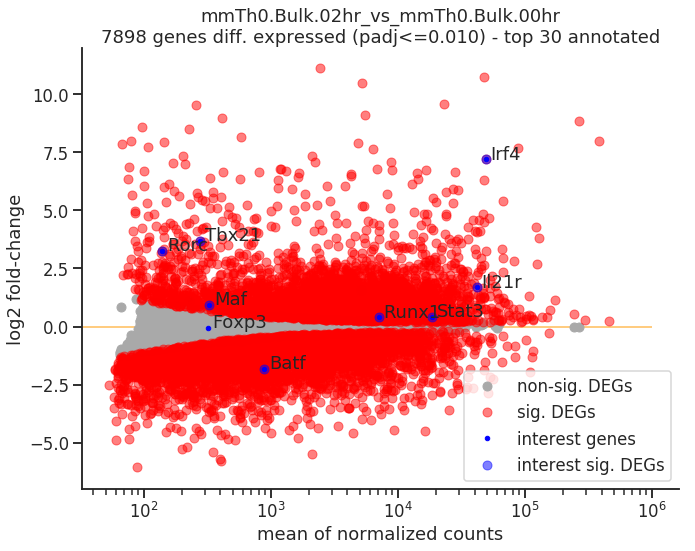

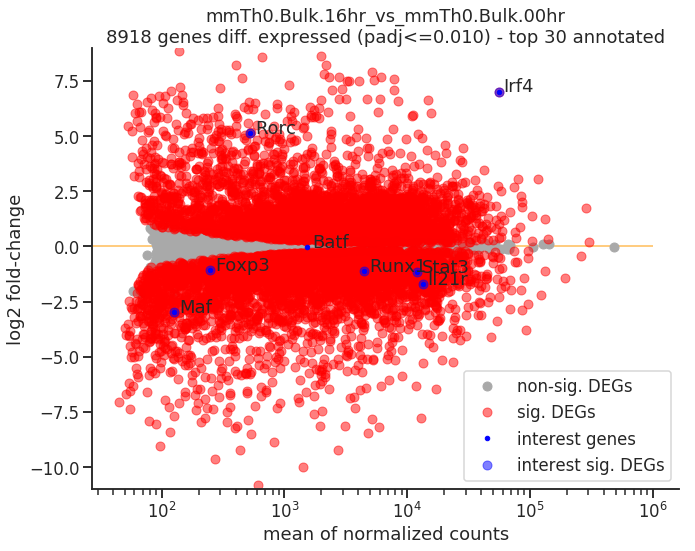

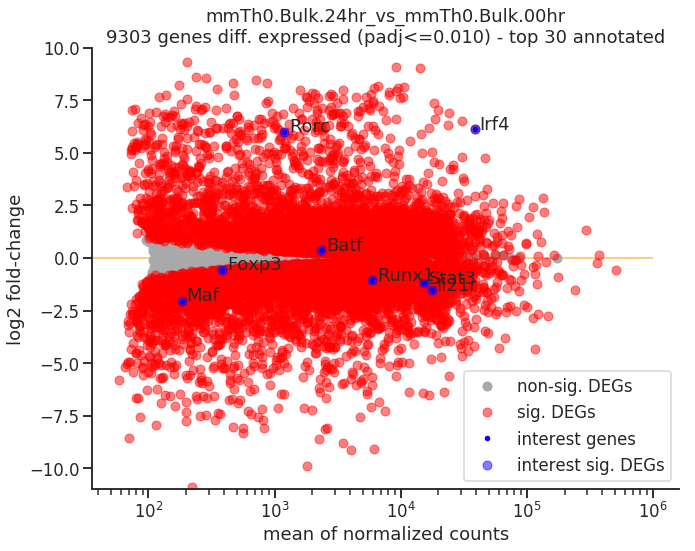

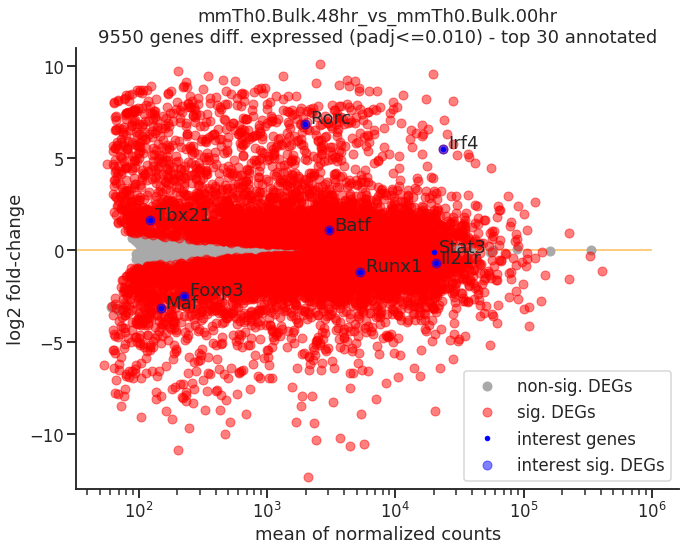

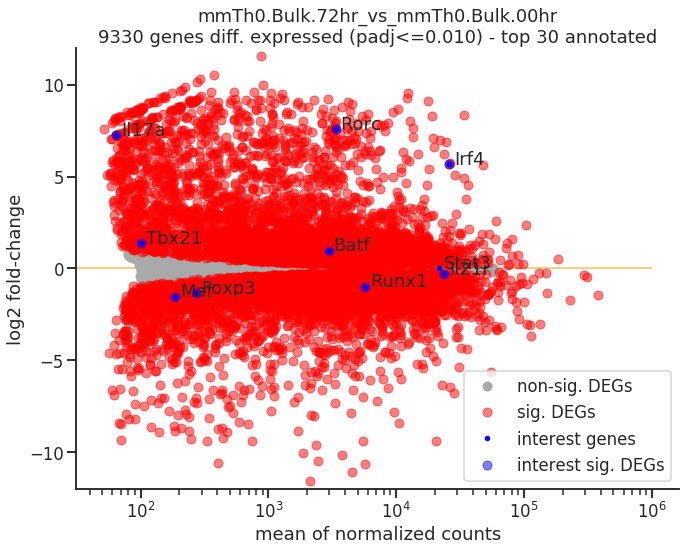

In [4]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.01
top_to_report = 30

special_genes = ['Maf', 'Il17a', 'Rorc', 'Stat3', 'Stat5', 'Batf', 'Irf4', 'Runx1', 'Il21r', 'Tbx21', 'Foxp3']
comparisons = [
     'mmTh0.Bulk.02hr_vs_mmTh0.Bulk.00hr',
     'mmTh0.Bulk.16hr_vs_mmTh0.Bulk.00hr', 
     'mmTh0.Bulk.24hr_vs_mmTh0.Bulk.00hr', 
     'mmTh0.Bulk.48hr_vs_mmTh0.Bulk.00hr',
     'mmTh0.Bulk.72hr_vs_mmTh0.Bulk.00hr'
]

data_dir = '/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/mmTh0'

for comparison in comparisons:
    df = pd.read_csv("%s/%s.with_genes.txt" % (data_dir, comparison),
                    sep="\t")
#     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
#                     sep="\t",
#                     names=['GeneName', 'GeneType'])
#     df = df.merge(df_gene_name_type, on='GeneName')
#     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
#     df = df[~df.GeneType.isin(pseudogene_types)]
#     df = df[df.GeneType.isin(['protein_coding'])]
    fig = plt.figure(figsize=(10,8))
    ax = plt.subplot(1, 1, 1)
    df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
    ax.set_xscale('log')
    ax.plot(df_non_sig['baseMean'].values, 
            df_non_sig['log2FoldChange'].values, 
            'o', color='darkgrey', label='non-sig. DEGs')

    
    ylims = [np.ceil(df['log2FoldChange'].min()-1), 
             np.floor(df['log2FoldChange'].max()+1)]
    df_sig = df[df.padj<=pval_thres]
    ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.5, label='sig. DEGs')

    # Annotate the top top_to_report
    df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)
    df_annotate_table = df_sig.sort_values(by='padj', ascending=True)

#     if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
#         df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
#     ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', label='sig. DEGs')

#     for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
#         ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
#                     textcoords='offset points')

    # Annotate in particular IL1RN, HBG and EP300
    df_annotate_selected = df[df.GeneName.isin(special_genes)]
    ax.plot(df_annotate_selected['baseMean'].values, 
            df_annotate_selected['log2FoldChange'].values,color='blue', 
            marker='.', linestyle = 'None', alpha=1, label='interest genes')
    for x, y, t in zip(df_annotate_selected['baseMean'].values,
                       df_annotate_selected['log2FoldChange'].values, 
                       df_annotate_selected['GeneName'].values) :
        ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                textcoords='offset points')
    df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
    ax.plot(df_annotate_selected['baseMean'].values, 
            df_annotate_selected['log2FoldChange'].values,color='blue', 
            marker='o', linestyle = 'None', alpha=0.5, label='interest sig. DEGs')
    
    

    plt.ylim(ylims)
    plt.xlabel("mean of normalized counts")
    plt.ylabel("log2 fold-change")
    plt.title("%s\n%d genes diff. expressed (padj<=%.3f) - top %d annotated" % (comparison, 
                                                                                np.count_nonzero(df.padj<=pval_thres), 
                                                                                pval_thres, 
                                                                                top_to_report))
    plt.hlines(0, 0, 1e6, color='#ffcc80', linewidth =2 )
    plt.legend()

    # Remove spines and tight the layout
    simpleaxis(ax)
    plt.tight_layout()
    
#     # Save annotated MA plot
    plt.savefig("/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/mmTh0/degs.%s.with_genes.annotated_plot_MA.pdf" % comparison)
    
     # Save annotated genes without pseudogenes
    df_annotate_table.to_csv("/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/mmTh0/%s.with_genes.sig_DE.txt" % comparison,
                       sep='\t',
                       index=False)
    
    # print table of values 
    print ("======", comparison, "======")
    display(df_annotate) 


### DE analysis for Th17 cells taking 00hr as the control and other timestamps as treatment samples

Data manipulation for DEseq analysis

In [1]:
import glob
import re
import pandas as pd

comp_files = {
     'Th17.Bulk.02hr': [
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep1.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep1.star2.featurecounts.counts.txt'
    ],
    
    'Th17.Bulk.16hr': [
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep1.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep1.star2.featurecounts.counts.txt'
    ],
    
    'Th17.Bulk.24hr': [
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep1.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep1.star2.featurecounts.counts.txt'
    ],
    
    'Th17.Bulk.48hr': [
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep1.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep1.star2.featurecounts.counts.txt'
    ], 
    
    'Th17.Bulk.72hr': [
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep1.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep1.star2.featurecounts.counts.txt'
    ],
    
    'Th17.Sorted.72hr': [
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Sorted.rep1.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Sorted.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Sorted.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Sorted.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep1.star2.featurecounts.counts.txt'
    ]
}

def clean_count_column(s):
    items = ['bulk', 'Bulk']
    name = '.'.join(s.split('/')[-1].split('.')[:3])
    if name.startswith('mm'):
        if any(i in s for i in items):
            return '.'.join(s.split('/')[-1].replace('.rna_seq.activated_bulk','.Bulk').replace('h.','hr.').split('.')[:4])
        else:
            return '.'.join(s.split('/')[-1].replace('.rna_seq.activated','.Bulk').replace('h.','hr.').split('.')[:4])
        
    else:
        if any(i in s for i in items):
            split_words = '.'.join(s.split('.')[1:3])
            rev_words = '.'.join(list(reversed(s.split('.')[1:3])))
            return '.'.join(s.split('/')[-1].replace(split_words, rev_words).split('.')[:4])
        else:
            s = re.sub('17.', '17.Bulk.', s)
            return '.'.join(s.split('/')[-1].split('.')[:4])
        
        
for comp, files in comp_files.items():
    df = None
    for f in files:
        df_tmp = pd.read_csv(f, sep='\t', skiprows=1, index_col=0)
        df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_count_column(f)]
        if df is None:
            df = df_tmp.loc[:, ['Chr', 'Start', 'End'] + [df_tmp.columns[-1]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-1]], how='right')

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='int')

    df.to_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/%s.counts.txt' % comp, sep='\t')

In [7]:
import pandas as pd
import glob
import re


cfiles = {
    'Th17.Sorted.72hr': [
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Sorted.rep1.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Sorted.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Sorted.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Sorted.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.00hr.rep1.star2.featurecounts.counts.txt'
    ]
}

def clean_count_column(s):
    items = ['sorted', 'Sorted']
    name = '.'.join(s.split('/')[-1].split('.')[:3])
    if any(i in s for i in items):
        split_words = '.'.join(s.split('.')[1:3])
        rev_words = '.'.join(list(reversed(s.split('.')[1:3])))
        return '.'.join(s.split('/')[-1].replace(split_words, rev_words).split('.')[:4])
    else:
        s = re.sub('17.', '17.Bulk.', s)
        return '.'.join(s.split('/')[-1].split('.')[:4])

        
for comp, files in cfiles.items():
    df = None
    for f in files:
        df_tmp = pd.read_csv(f, sep='\t', skiprows=1, index_col=0)
        df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_count_column(f)]
        if df is None:
            df = df_tmp.loc[:, ['Chr', 'Start', 'End'] + [df_tmp.columns[-1]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-1]], how='right')

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='int')
    df.to_csv('/data/reddylab/Revathy/collabs/rna-seq_Siklenka/%s.counts.txt' % comp, sep='\t')
df

Chr                            Start  \
Geneid                                                                       
ENSMUSG00000102693.1                 chr1                          3073253   
ENSMUSG00000064842.1                 chr1                          3102016   
ENSMUSG00000051951.5  chr1;chr1;chr1;chr1  3205901;3213439;3421702;3670552   
ENSMUSG00000102851.1                 chr1                          3252757   
ENSMUSG00000103377.1                 chr1                          3365731   
...                                   ...                              ...   
ENSMUSG00000064368.1                 chrM                            13552   
ENSMUSG00000064369.1                 chrM                            14071   
ENSMUSG00000064370.1                 chrM                            14145   
ENSMUSG00000064371.1                 chrM                            15289   
ENSMUSG00000064372.1                 chrM                            15356   

                                                  End  Th17.Sorted.72hr.rep1  \
Geneid                                                                         
ENSMUSG00000102693.1                          3074322                      0   
ENSMUSG00000064842.1                          3102125                      0   
ENSMUSG00000051951.5  3207317;3216968;3421901;3671498                      0   
ENSMUSG00000102851.1                          3253236                      0   
ENSMUSG00000103377.1                          3368549                      0   
...                                               ...                    ...   
ENSMUSG00000064368.1                            14070                    322   
ENSMUSG00000064369.1                            14139                      3   
ENSMUSG00000064370.1                            15288                  68654   
ENSMUSG00000064371.1                            15355                     63   
ENSMUSG00000064372.1                            15422                      4   

                      Th17.Sorted.72hr.rep2  Th17.Sorted.72hr.rep3  \
Geneid                                                               
ENSMUSG00000102693.1                      0                      0   
ENSMUSG00000064842.1                      0                      0   
ENSMUSG00000051951.5                      0                      0   
ENSMUSG00000102851.1                      0                      0   
ENSMUSG00000103377.1                      0                      0   
...                                     ...                    ...   
ENSMUSG00000064368.1                    239                     72   
ENSMUSG00000064369.1                      0                      0   
ENSMUSG00000064370.1                  45049                  18968   
ENSMUSG00000064371.1                     58                     18   
ENSMUSG00000064372.1                      7                      4   

                      Th17.Sorted.72hr.rep4  Th17.Bulk.00hr.rep2  \
Geneid                                                             
ENSMUSG00000102693.1                      0                    0   
ENSMUSG00000064842.1                      0                    0   
ENSMUSG00000051951.5                      0                    0   
ENSMUSG00000102851.1                      0                    0   
ENSMUSG00000103377.1                      0                    0   
...                                     ...                  ...   
ENSMUSG00000064368.1                    297                   84   
ENSMUSG00000064369.1                      3                    0   
ENSMUSG00000064370.1                  64646               115113   
ENSMUSG00000064371.1                     54                    3   
ENSMUSG00000064372.1                     11                    0   

                      Th17.Bulk.00hr.rep3  Th17.Bulk.00hr.rep4  \
Geneid                                                           
ENSMUSG00000102693.1                    0             

DEseq analysis

In [9]:
%%bash
mkdir -p /data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/Th17
source /data/reddylab/software/miniconda3/bin/activate alex_py3
sbatch -pnew,all \
    --mem 16G \
    -o /data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/Th17_sorted.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
#      Th17.Bulk.02hr-Th17.Bulk.00hr \
#      Th17.Bulk.16hr-Th17.Bulk.00hr \ 
#      Th17.Bulk.24hr-Th17.Bulk.00hr \
#      Th17.Bulk.48hr-Th17.Bulk.00hr \
#      Th17.Bulk.72hr-Th17.Bulk.00hr \
     Th17.Sorted.72hr-Th17.Bulk.00hr
)
COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREATMENT=$(echo $COMPARISON | cut -d"-" -f1)
CONTROL=$(echo $COMPARISON | cut -d"-" -f2)
FACTOR=$(echo $COMPARISON | cut -d"-" -f1)
Rscript /data/reddylab/Revathy/scripts/rnaseq_dge.deseq2_v2.R \
    --treatments $(echo ${TREATMENT}.rep{1,2,3,4})\
    --controls $(echo ${CONTROL}.rep{1,2,3,4}) \
    --lfcShrink ashr \
    --counts-skip-ncols 3 \
    --outdir /data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/Th17 \
    --counts /data/reddylab/Revathy/collabs/rna-seq_Siklenka/${FACTOR}.counts.txt
    
EOF


Submitted batch job 25441066


In [11]:
%%bash
FDR=0.05
COMPARISONS=( \ 
#      Th17.Bulk.02hr_vs_Th17.Bulk.00hr \
#      Th17.Bulk.16hr_vs_Th17.Bulk.00hr \
#      Th17.Bulk.24hr_vs_Th17.Bulk.00hr \ 
#      Th17.Bulk.48hr_vs_Th17.Bulk.00hr \
#      Th17.Bulk.72hr_vs_Th17.Bulk.00hr \
     Th17.Sorted.72hr_vs_Th17.Bulk.00hr \
)
cd /data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/Th17
for COMP in ${COMPARISONS[@]};
do
    # Save expressed genes (more than 5 normalized counts)
    tail -n+2 ${COMP}.txt |  cut -d. -f1 > ${COMP}.expressed_genes.txt 
    
    # Save significant upreg genes
    tail -n+2 ${COMP}.txt |  awk -vFDR=${FDR} '{if(($NF<FDR) && ($3>0)){print $1}}' |  cut -d. -f1 > ${COMP}.upreg_genes.txt 

    # Save significant downreg genes
    tail -n+2 ${COMP}.txt |  awk -vFDR=${FDR} '{if(($NF<FDR) && ($3<0)){print $1}}' |  cut -d. -f1 > ${COMP}.downreg_genes.txt 

done

In [12]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
cd /data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/Th17
for ii in $(/bin/ls -1 *_vs_*hr.txt | /bin/grep -v with_genes);
do
    python /data/reddylab/Alex/collab/20180628_Layden/processing/rna_seq/scripts/mm10.rnaseq_dge_deseq2.add_gene_names.py \
        ${ii} \
        ${ii/.txt/.with_genes.txt}
done

In [13]:
%%bash
FDR=0.05
COMPARISONS=( \
#      Th17.Bulk.02hr_vs_Th17.Bulk.00hr \
#      Th17.Bulk.16hr_vs_Th17.Bulk.00hr \
#      Th17.Bulk.24hr_vs_Th17.Bulk.00hr \ 
#      Th17.Bulk.48hr_vs_Th17.Bulk.00hr \
#      Th17.Bulk.72hr_vs_Th17.Bulk.00hr \
     Th17.Sorted.72hr_vs_Th17.Bulk.00hr \
)
cd /data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/Th17
for COMP in ${COMPARISONS[@]};
do
    # Save expressed genes (more than 5 normalized counts)
    tail -n+2 ${COMP}.with_genes.txt |  awk '{print $NF}' > ${COMP}.expressed_genes.symbols.txt 

    # Save significant upreg genes
    tail -n+2 ${COMP}.with_genes.txt |  awk -vFDR=${FDR} '{if(($(NF-1)<FDR) && ($3>0)){print $NF}}' > ${COMP}.upreg_genes.symbols.txt 

    # Save significant downreg genes
    tail -n+2 ${COMP}.with_genes.txt |  awk -vFDR=${FDR} '{if(($(NF-1)<FDR) && ($3<0)){print $NF}}' > ${COMP}.downreg_genes.symbols.txt 

done

In [14]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
cd /data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/Th17
module load ImageMagick/7.0.1-gcb01
for ii in $(/bin/ls -1 *.pdf);
do
    convert ${ii} ${ii/.pdf/.png}
done

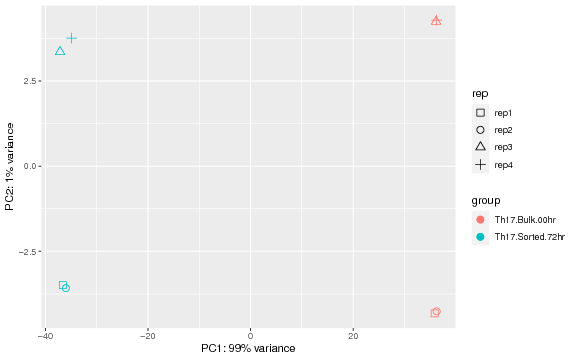

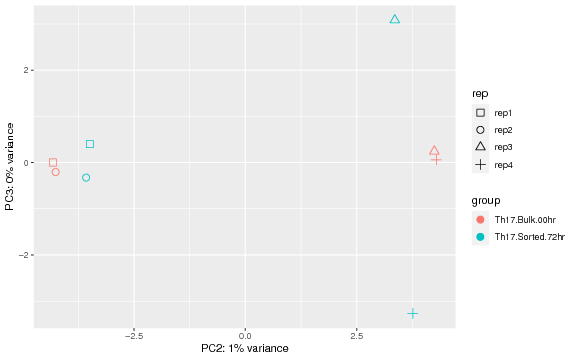

In [15]:
from IPython.display import display, Image
COMPARISONS=[
#      'Th17.Bulk.02hr_vs_Th17.Bulk.00hr',
#      'Th17.Bulk.16hr_vs_Th17.Bulk.00hr', 
#      'Th17.Bulk.24hr_vs_Th17.Bulk.00hr', 
#      'Th17.Bulk.48hr_vs_Th17.Bulk.00hr',
#      'Th17.Bulk.72hr_vs_Th17.Bulk.00hr',
     'Th17.Sorted.72hr_vs_Th17.Bulk.00hr'
    ]
PC = [
    'pca.1_vs_2',
    'pca.2_vs_3'
]

for p in PC:
    for comp in COMPARISONS:
         display(Image("/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/Th17/%s.%s.png" % (comp, p)))
            

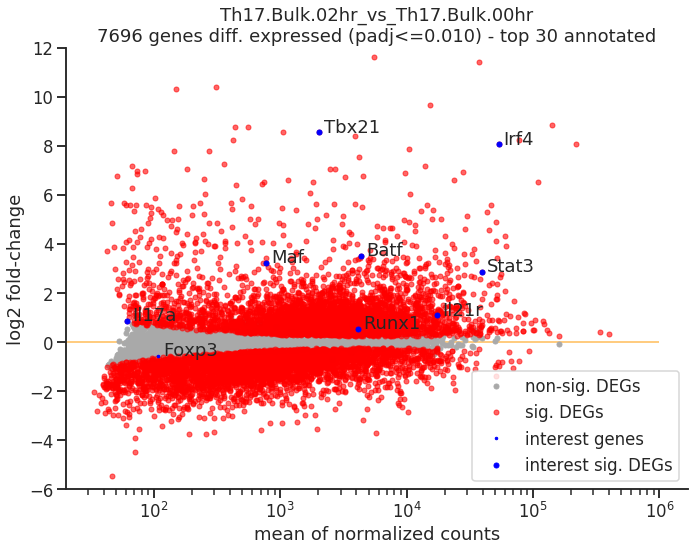

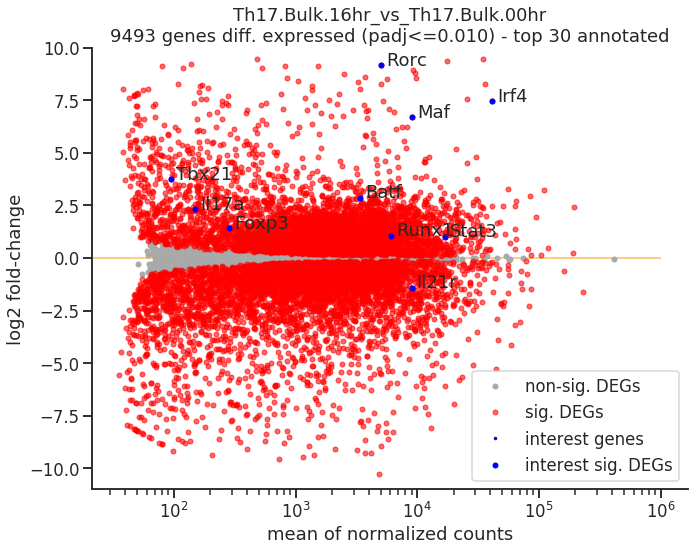

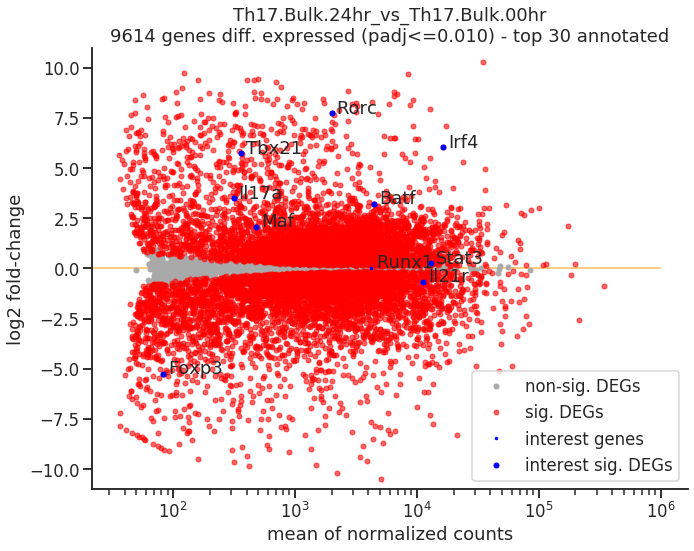

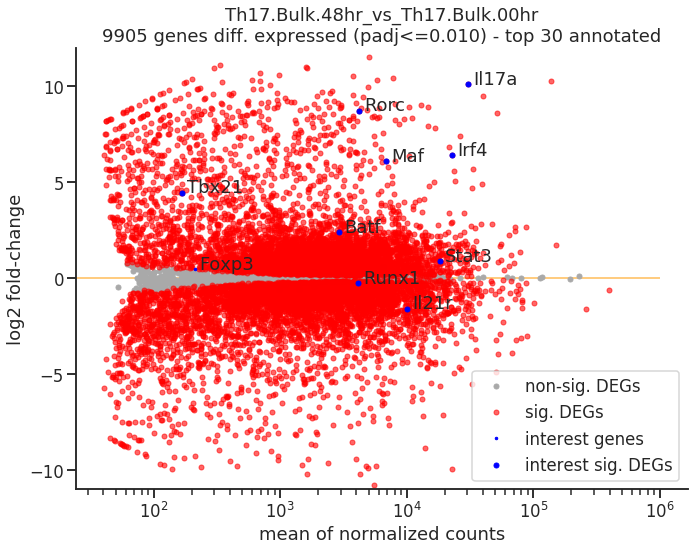

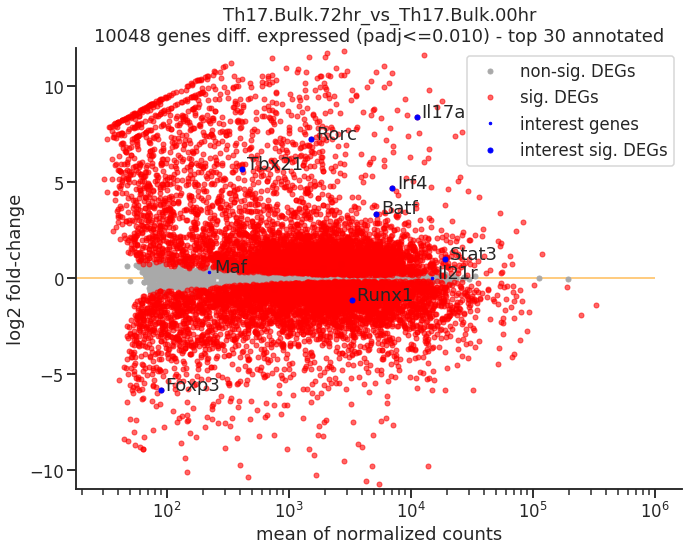

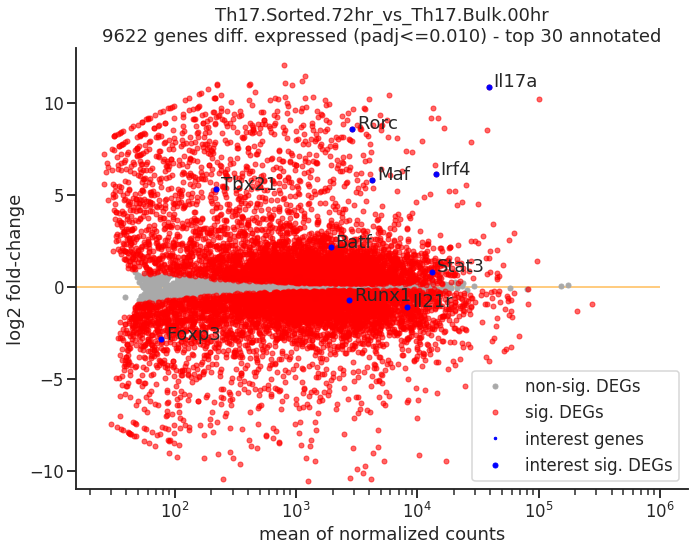

In [11]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.01
top_to_report = 30

special_genes = ['Maf', 'Il17a', 'Rorc', 'Stat3', 'Stat5', 'Batf', 'Irf4', 'Runx1', 'Il21r', 'Tbx21', 'Foxp3']
comparisons = [
     'Th17.Bulk.02hr_vs_Th17.Bulk.00hr',
     'Th17.Bulk.16hr_vs_Th17.Bulk.00hr', 
     'Th17.Bulk.24hr_vs_Th17.Bulk.00hr', 
     'Th17.Bulk.48hr_vs_Th17.Bulk.00hr',
     'Th17.Bulk.72hr_vs_Th17.Bulk.00hr',
     'Th17.Sorted.72hr_vs_Th17.Bulk.00hr'
]

data_dir = '/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/Th17'

for comparison in comparisons:
    df = pd.read_csv("%s/%s.with_genes.txt" % (data_dir, comparison),
                    sep="\t")
#     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
#                     sep="\t",
#                     names=['GeneName', 'GeneType'])
#     df = df.merge(df_gene_name_type, on='GeneName')
#     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
#     df = df[~df.GeneType.isin(pseudogene_types)]
#     df = df[df.GeneType.isin(['protein_coding'])]
    fig = plt.figure(figsize=(10,8))
    ax = plt.subplot(1, 1, 1)
    df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
    ax.set_xscale('log')
    ax.plot(df_non_sig['baseMean'].values, 
            df_non_sig['log2FoldChange'].values, 
            'o', color='darkgrey', label='non-sig. DEGs', markersize=5)

    
    ylims = [np.ceil(df['log2FoldChange'].min()-1), 
             np.floor(df['log2FoldChange'].max()+1)]
    df_sig = df[df.padj<=pval_thres]
    ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.6, label='sig. DEGs', markersize=5)

    # Annotate the top top_to_report
    df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)
    df_annotate_table = df_sig.sort_values(by='padj', ascending=True)

#     if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
#         df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
#     ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', label='sig. DEGs')

#     for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
#         ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
#                     textcoords='offset points')

    # Annotate in particular IL1RN, HBG and EP300
    df_annotate_selected = df[df.GeneName.isin(special_genes)]
    ax.plot(df_annotate_selected['baseMean'].values, 
            df_annotate_selected['log2FoldChange'].values,color='blue', 
            marker='.', linestyle = 'None', alpha=1, label='interest genes', markersize=5)
    for x, y, t in zip(df_annotate_selected['baseMean'].values,
                       df_annotate_selected['log2FoldChange'].values, 
                       df_annotate_selected['GeneName'].values) :
        ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                textcoords='offset points')
    df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
    ax.plot(df_annotate_selected['baseMean'].values, 
            df_annotate_selected['log2FoldChange'].values,color='blue', 
            marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs', markersize=5)
    
    

    plt.ylim(ylims)
    plt.xlabel("mean of normalized counts")
    plt.ylabel("log2 fold-change")
    plt.title("%s\n%d genes diff. expressed (padj<=%.3f) - top %d annotated" % (comparison, 
                                                                                np.count_nonzero(df.padj<=pval_thres), 
                                                                                pval_thres, 
                                                                                top_to_report))
    plt.hlines(0, 0, 1e6, color='#ffcc80', linewidth =2 )
    plt.legend()

    # Remove spines and tight the layout
    simpleaxis(ax)
    plt.tight_layout()
    
#     # Save annotated MA plot
    plt.savefig("/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/Th17/degs.%s.with_genes.annotated_plot_MA.png" % comparison)
    
     # Save annotated genes without pseudogenes
    df_annotate_table.to_csv("/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/Th17/%s.with_genes.sig_DE.txt" % comparison,
                       sep='\t',
                       index=False)
    
#     # print table of values 
#     print ("======", comparison, "======")
#     display(df_annotate) 


In [12]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
cd /data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/Th17
module load ImageMagick/7.0.1-gcb01
for ii in $(/bin/ls -1 *.png);
do
    convert ${ii} ${ii/.png/.pdf}
done

### Differential expression analysis for Th17 with comaprison between each time point

In [5]:

import glob
import re
import pandas as pd

comp_files = {
     'Th17.Bulk.16hr-Th17.Bulk.02hr': [
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep1.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep1.star2.featurecounts.counts.txt'
    ],
    
    'Th17.Bulk.24hr-Th17.Bulk.02hr': [
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep1.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep1.star2.featurecounts.counts.txt'
    ],
    
    
    'Th17.Bulk.48hr-Th17.Bulk.02hr': [
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep1.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep1.star2.featurecounts.counts.txt'
    ], 
    
    'Th17.Bulk.72hr-Th17.Bulk.02hr': [
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep1.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.02hr.rep1.star2.featurecounts.counts.txt'
    ],
    
    'Th17.Bulk.24hr-Th17.Bulk.16hr': [
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep1.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep1.star2.featurecounts.counts.txt'
    ],
    
    
    'Th17.Bulk.48hr-Th17.Bulk.16hr': [
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep1.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep1.star2.featurecounts.counts.txt'
    ], 
    
    'Th17.Bulk.72hr-Th17.Bulk.16hr': [
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep1.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.16hr.rep1.star2.featurecounts.counts.txt'
    ],
    
    'Th17.Bulk.48hr-Th17.Bulk.24hr': [
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep1.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep1.star2.featurecounts.counts.txt'
    ], 
    
    'Th17.Bulk.72hr-Th17.Bulk.24hr': [
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep1.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.24hr.rep1.star2.featurecounts.counts.txt'
    ],
    
    'Th17.Bulk.72hr-Th17.Bulk.48hr': [
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.72hr.Bulk.rep1.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep2.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep3.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep4.star2.featurecounts.counts.txt',
  '/data/reddylab/projects/encode4_duke/processing/rna_seq/Siklenka_6358_200714B6-pe-revstranded-with-sjdb/Th17.48hr.rep1.star2.featurecounts.counts.txt'
    ]
    
}

def clean_count_column(s):
    items = ['bulk', 'Bulk']
    name = '.'.join(s.split('/')[-1].split('.')[:3])
    if name.startswith('mm'):
        if any(i in s for i in items):
            return '.'.join(s.split('/')[-1].replace('.rna_seq.activated_bulk','.Bulk').replace('h.','hr.').split('.')[:4])
        else:
            return '.'.join(s.split('/')[-1].replace('.rna_seq.activated','.Bulk').replace('h.','hr.').split('.')[:4])
        
    else:
        if any(i in s for i in items):
            split_words = '.'.join(s.split('.')[1:3])
            rev_words = '.'.join(list(reversed(s.split('.')[1:3])))
            return '.'.join(s.split('/')[-1].replace(split_words, rev_words).split('.')[:4])
        else:
            s = re.sub('17.', '17.Bulk.', s)
            return '.'.join(s.split('/')[-1].split('.')[:4])
        
        
for comp, files in comp_files.items():
    df = None
    for f in files:
        df_tmp = pd.read_csv(f, sep='\t', skiprows=1, index_col=0)
        df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_count_column(f)]
        if df is None:
            df = df_tmp.loc[:, ['Chr', 'Start', 'End'] + [df_tmp.columns[-1]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-1]], how='right')

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='int')

    df.to_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/pairwise/Th17/%s.counts.txt' % comp, sep='\t')

In [7]:
%%bash
mkdir -p /data/reddylab/Revathy/dev/rna-seq_Siklenka/pairwise/Th17/deseq2
source /data/reddylab/software/miniconda3/bin/activate alex_py3
sbatch -pnew,all \
    --array=0-1 \
    --mem 16G \
    -o /data/reddylab/Revathy/dev/rna-seq_Siklenka/pairwise/Th17/deseq2/Th17.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
     Th17.Bulk.16hr-Th17.Bulk.02hr \ 
     Th17.Bulk.24hr-Th17.Bulk.02hr \
     Th17.Bulk.48hr-Th17.Bulk.02hr \
     Th17.Bulk.72hr-Th17.Bulk.02hr \
     Th17.Bulk.24hr-Th17.Bulk.16hr \
     Th17.Bulk.48hr-Th17.Bulk.16hr \
     Th17.Bulk.72hr-Th17.Bulk.16hr \
     Th17.Bulk.48hr-Th17.Bulk.24hr \
     Th17.Bulk.72hr-Th17.Bulk.24hr \
     Th17.Bulk.72hr-Th17.Bulk.48hr \
)
COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREATMENT=$(echo $COMPARISON | cut -d"-" -f1)
CONTROL=$(echo $COMPARISON | cut -d"-" -f2)
FACTOR=$(echo $COMPARISON)
Rscript /data/reddylab/Revathy/dev/scripts/rnaseq_dge.deseq2_v2.R \
    --treatments $(echo ${TREATMENT}.rep{1,2,3,4})\
    --controls $(echo ${CONTROL}.rep{1,2,3,4}) \
    --lfcShrink ashr \
    --counts-skip-ncols 3 \
    --outdir /data/reddylab/Revathy/dev/rna-seq_Siklenka/pairwise/Th17/deseq2 \
    --counts /data/reddylab/Revathy/dev/rna-seq_Siklenka/pairwise/Th17/${FACTOR}.counts.txt
    
EOF

Submitted batch job 24008518


In [8]:
%%bash
FDR=0.05
COMPARISONS=( \ 
     Th17.Bulk.16hr_vs_Th17.Bulk.02hr \
     Th17.Bulk.24hr_vs_Th17.Bulk.02hr \ 
     Th17.Bulk.48hr_vs_Th17.Bulk.02hr \
     Th17.Bulk.72hr_vs_Th17.Bulk.02hr \
     Th17.Bulk.24hr_vs_Th17.Bulk.16hr \ 
     Th17.Bulk.48hr_vs_Th17.Bulk.16hr \
     Th17.Bulk.72hr_vs_Th17.Bulk.16hr \ 
     Th17.Bulk.48hr_vs_Th17.Bulk.24hr \
     Th17.Bulk.72hr_vs_Th17.Bulk.24hr \
     Th17.Bulk.72hr_vs_Th17.Bulk.48hr \
)
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/pairwise/Th17/deseq2
for COMP in ${COMPARISONS[@]};
do
    # Save expressed genes (more than 5 normalized counts)
    tail -n+2 ${COMP}.txt |  cut -d. -f1 > ${COMP}.expressed_genes.txt 
    
    # Save significant upreg genes
    tail -n+2 ${COMP}.txt |  awk -vFDR=${FDR} '{if(($NF<FDR) && ($3>0)){print $1}}' |  cut -d. -f1 > ${COMP}.upreg_genes.txt 

    # Save significant downreg genes
    tail -n+2 ${COMP}.txt |  awk -vFDR=${FDR} '{if(($NF<FDR) && ($3<0)){print $1}}' |  cut -d. -f1 > ${COMP}.downreg_genes.txt 

done

In [9]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/pairwise/Th17/deseq2
for ii in $(/bin/ls -1 *_vs_*hr.txt | /bin/grep -v with_genes);
do
    python /data/reddylab/Alex/collab/20180628_Layden/processing/rna_seq/scripts/mm10.rnaseq_dge_deseq2.add_gene_names.py \
        ${ii} \
        ${ii/.txt/.with_genes.txt}
done

In [10]:
%%bash
FDR=0.05
COMPARISONS=( \
    Th17.Bulk.16hr_vs_Th17.Bulk.02hr \
     Th17.Bulk.24hr_vs_Th17.Bulk.02hr \ 
     Th17.Bulk.48hr_vs_Th17.Bulk.02hr \
     Th17.Bulk.72hr_vs_Th17.Bulk.02hr \
     Th17.Bulk.24hr_vs_Th17.Bulk.16hr \ 
     Th17.Bulk.48hr_vs_Th17.Bulk.16hr \
     Th17.Bulk.72hr_vs_Th17.Bulk.16hr \ 
     Th17.Bulk.48hr_vs_Th17.Bulk.24hr \
     Th17.Bulk.72hr_vs_Th17.Bulk.24hr \
     Th17.Bulk.72hr_vs_Th17.Bulk.48hr \
)
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/pairwise/Th17/deseq2
for COMP in ${COMPARISONS[@]};
do
    # Save expressed genes (more than 5 normalized counts)
    tail -n+2 ${COMP}.with_genes.txt |  awk '{print $NF}' > ${COMP}.expressed_genes.symbols.txt 

    # Save significant upreg genes
    tail -n+2 ${COMP}.with_genes.txt |  awk -vFDR=${FDR} '{if(($(NF-1)<FDR) && ($3>0)){print $NF}}' > ${COMP}.upreg_genes.symbols.txt 

    # Save significant downreg genes
    tail -n+2 ${COMP}.with_genes.txt |  awk -vFDR=${FDR} '{if(($(NF-1)<FDR) && ($3<0)){print $NF}}' > ${COMP}.downreg_genes.symbols.txt 

done

In [11]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/pairwise/Th17/deseq2
module load ImageMagick/7.0.1-gcb01
for ii in $(/bin/ls -1 *.pdf);
do
    convert ${ii} ${ii/.pdf/.png}
done

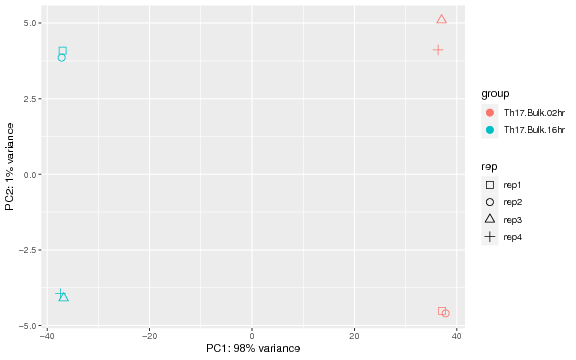

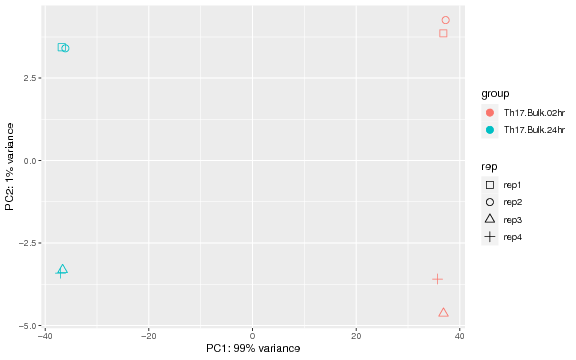

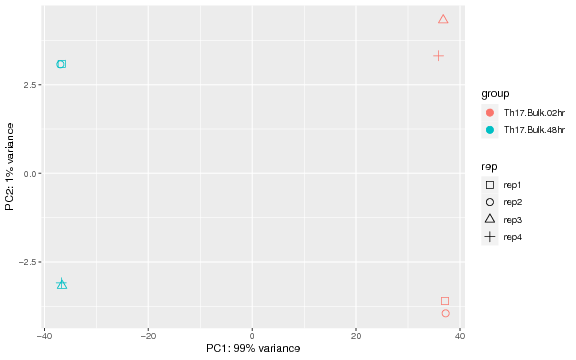

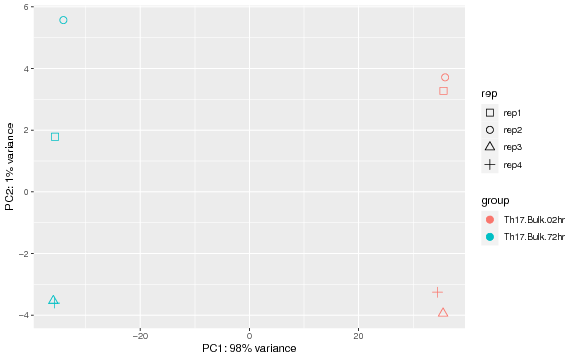

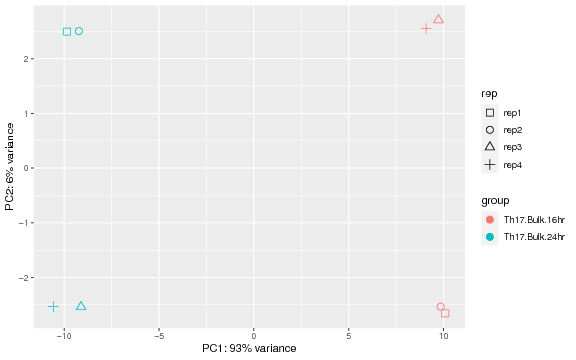

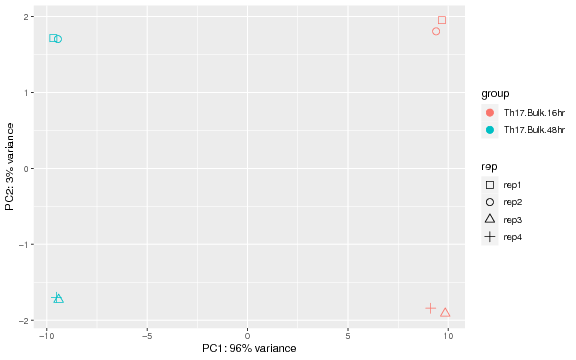

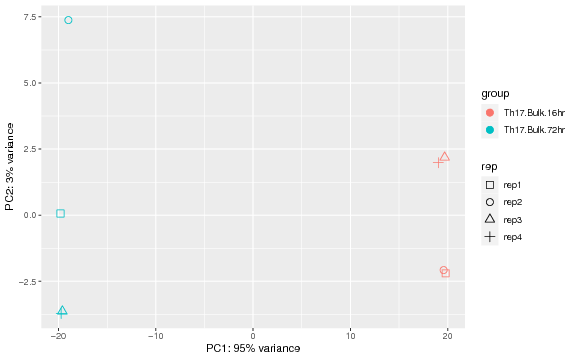

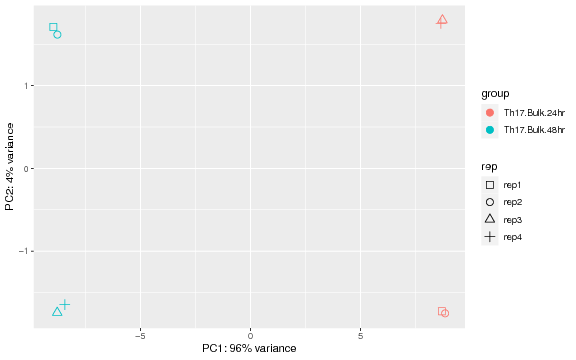

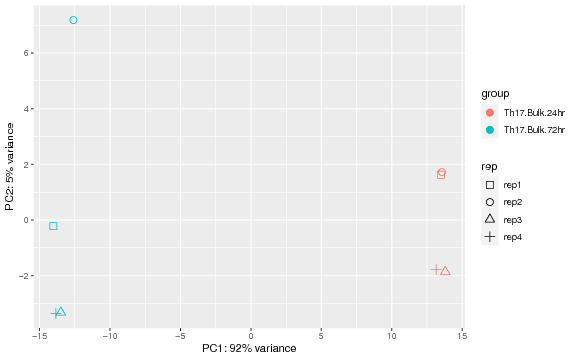

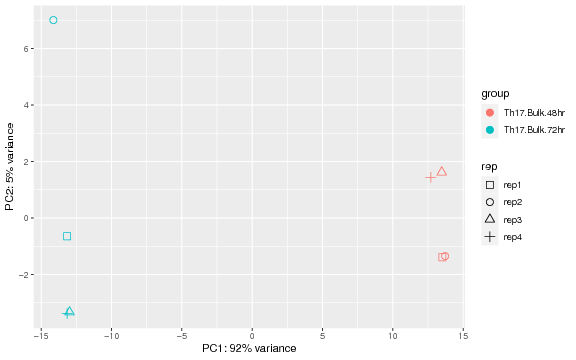

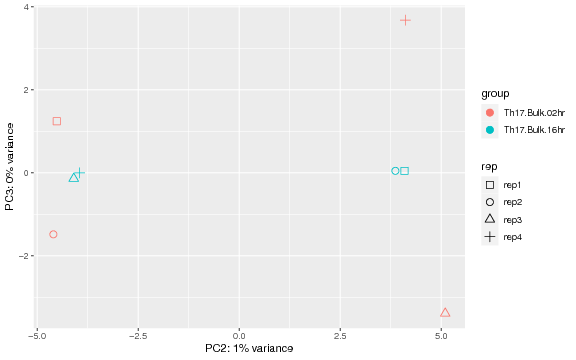

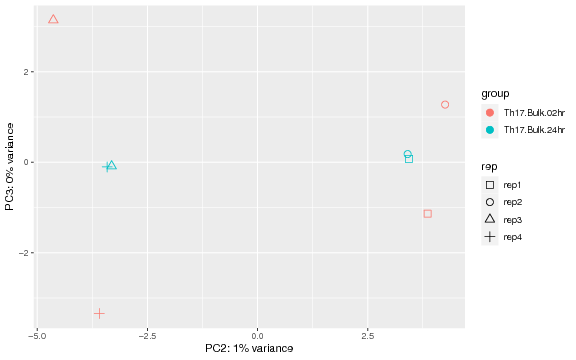

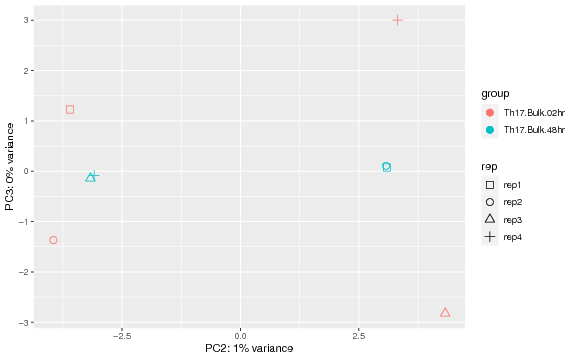

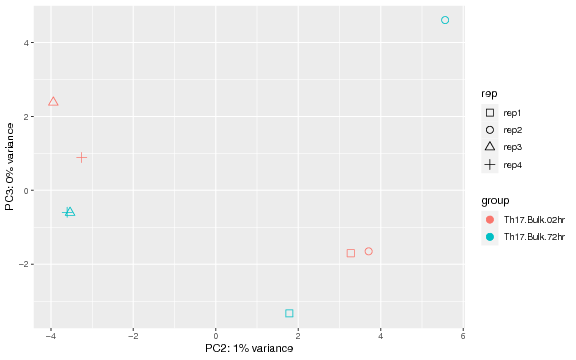

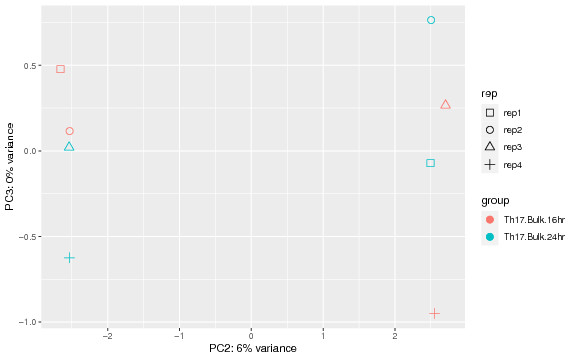

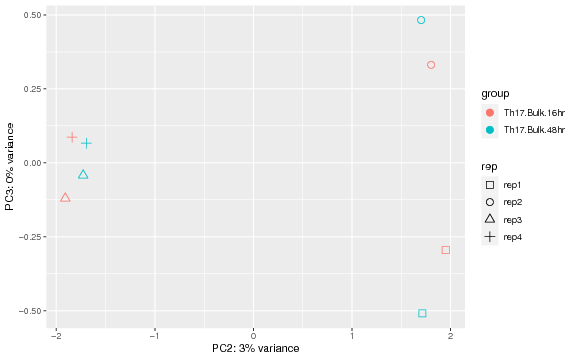

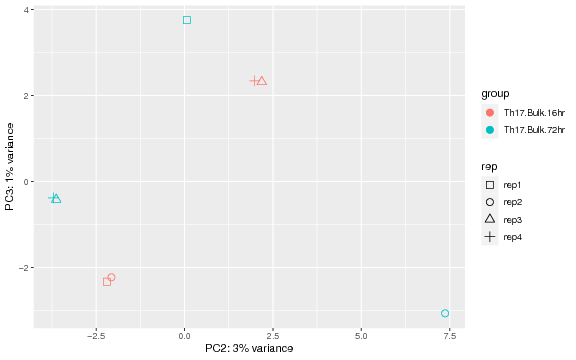

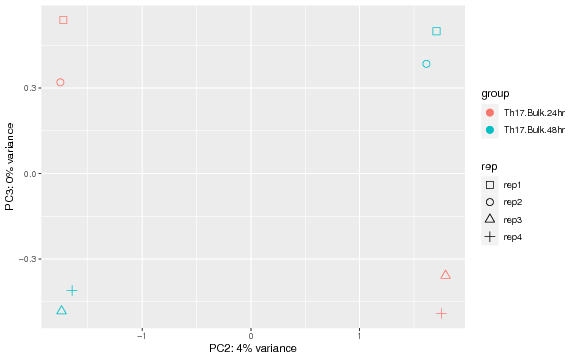

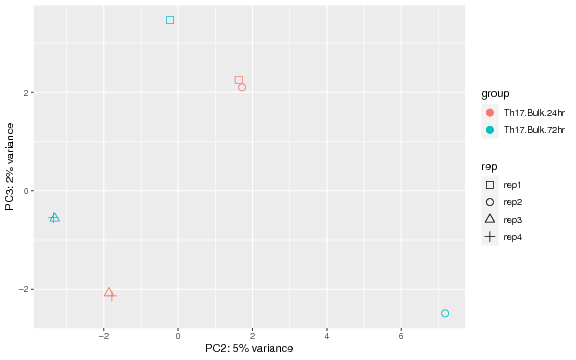

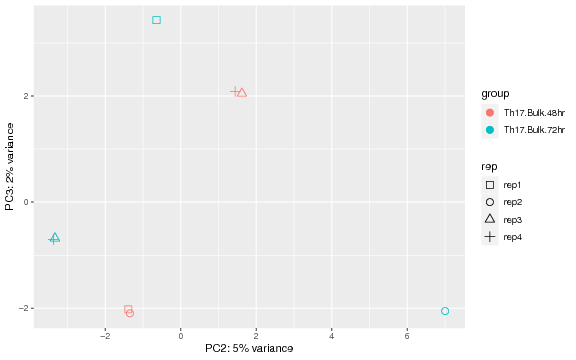

In [12]:
from IPython.display import display, Image
COMPARISONS=[
     'Th17.Bulk.16hr_vs_Th17.Bulk.02hr',
     'Th17.Bulk.24hr_vs_Th17.Bulk.02hr',  
     'Th17.Bulk.48hr_vs_Th17.Bulk.02hr',
     'Th17.Bulk.72hr_vs_Th17.Bulk.02hr',
     'Th17.Bulk.24hr_vs_Th17.Bulk.16hr',
     'Th17.Bulk.48hr_vs_Th17.Bulk.16hr',
     'Th17.Bulk.72hr_vs_Th17.Bulk.16hr',
     'Th17.Bulk.48hr_vs_Th17.Bulk.24hr',
     'Th17.Bulk.72hr_vs_Th17.Bulk.24hr',
     'Th17.Bulk.72hr_vs_Th17.Bulk.48hr'
    ]
PC = [
    'pca.1_vs_2',
    'pca.2_vs_3'
]

for p in PC:
    for comp in COMPARISONS:
         display(Image("/data/reddylab/Revathy/dev/rna-seq_Siklenka/pairwise/Th17/deseq2/%s.%s.png" % (comp, p)))

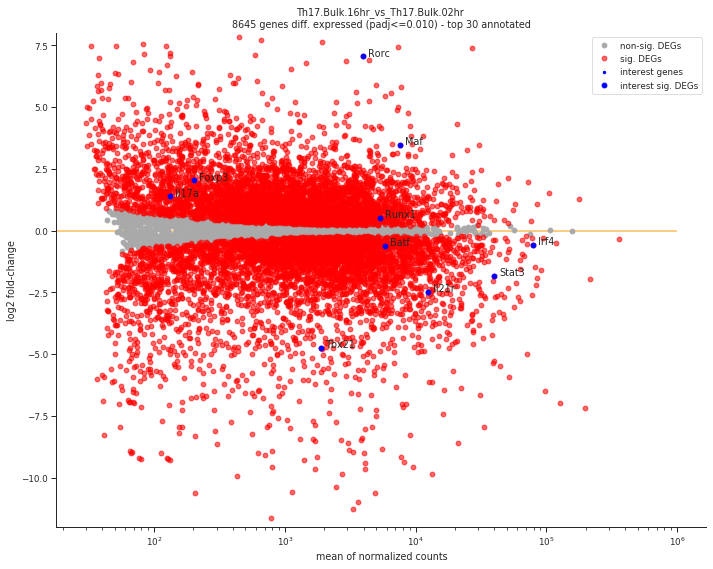

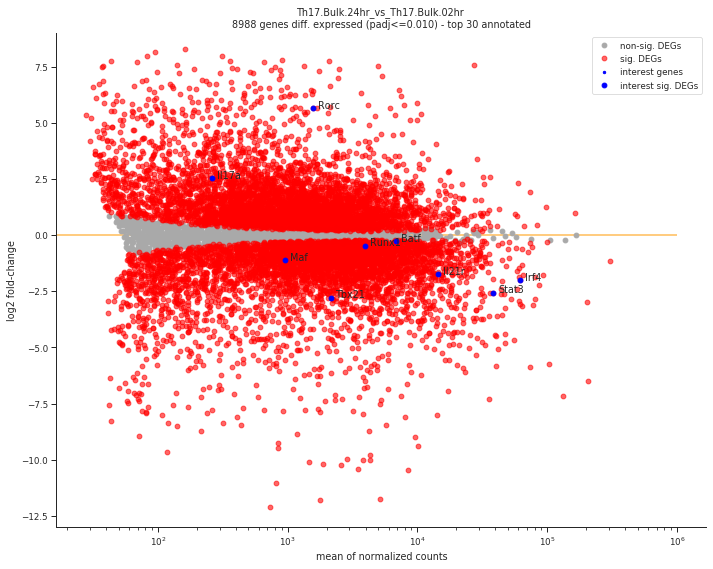

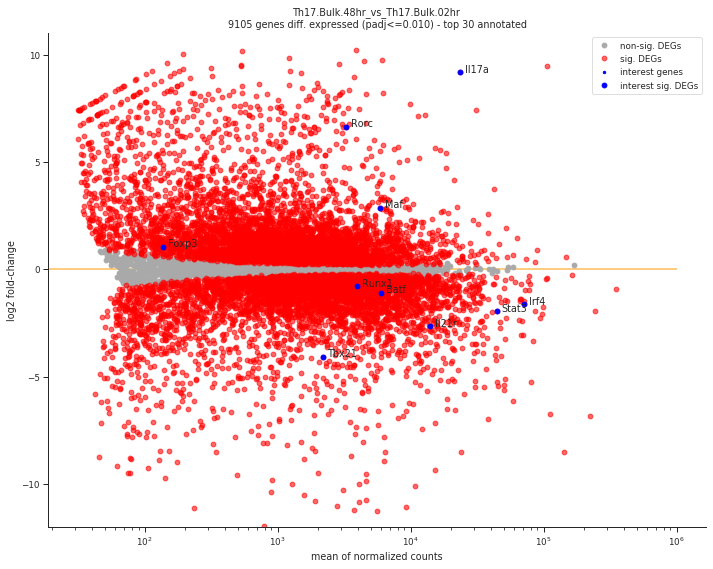

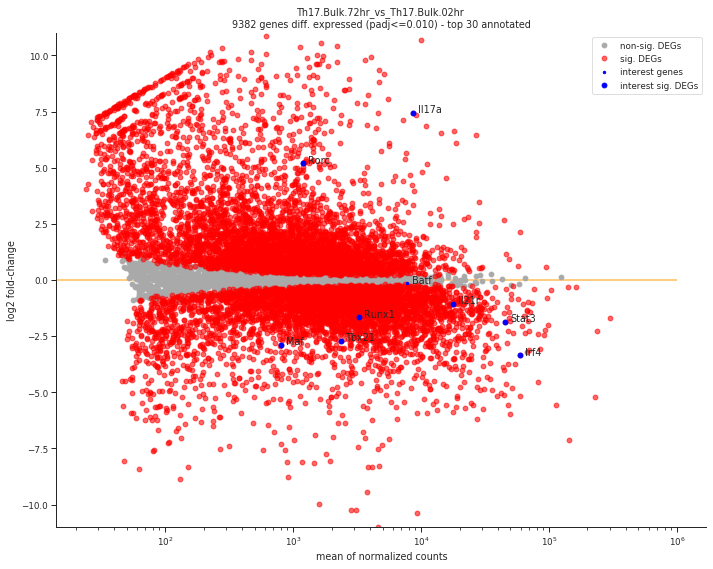

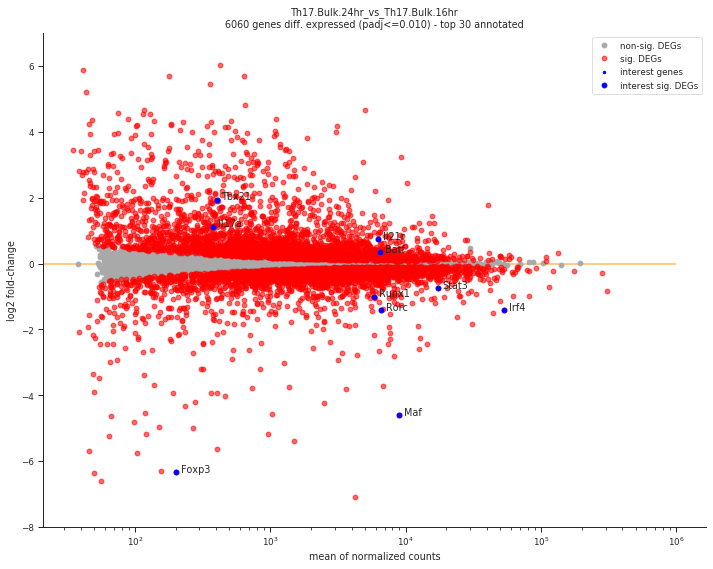

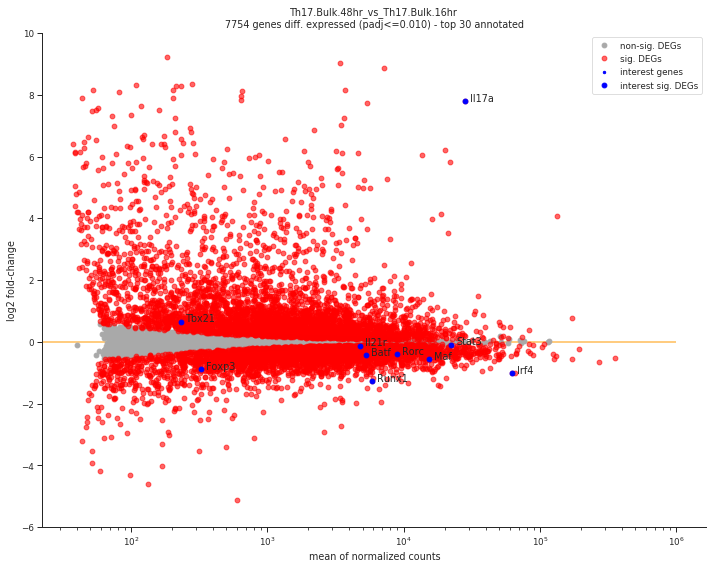

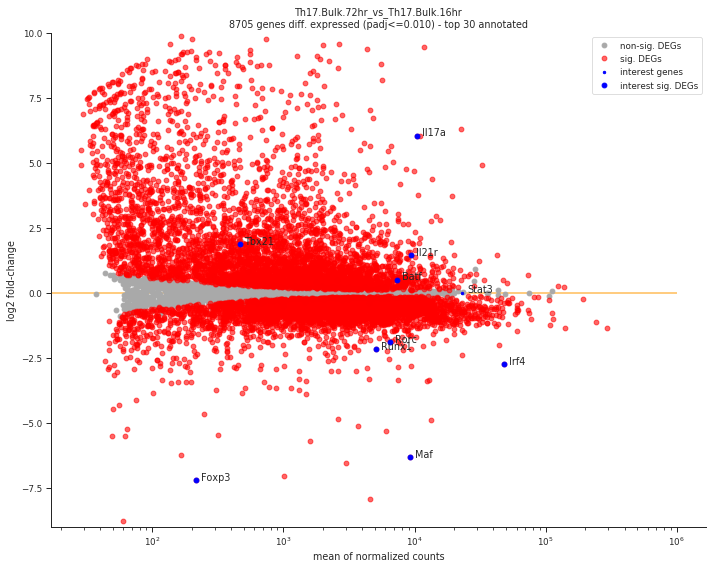

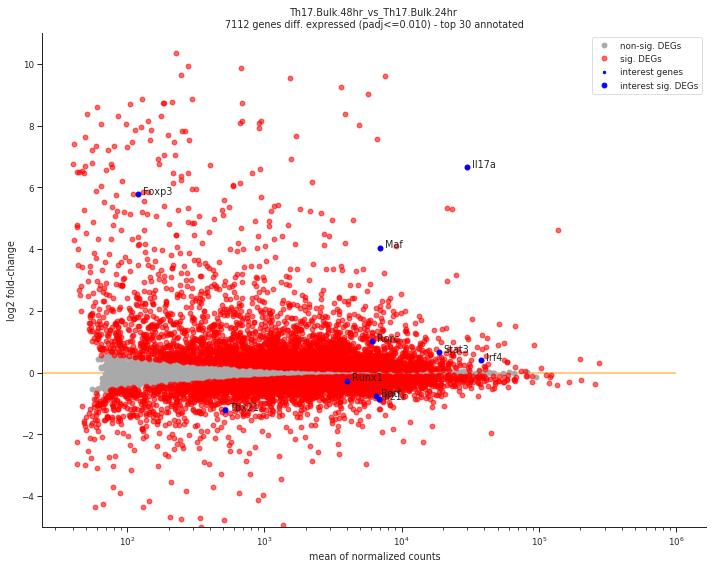

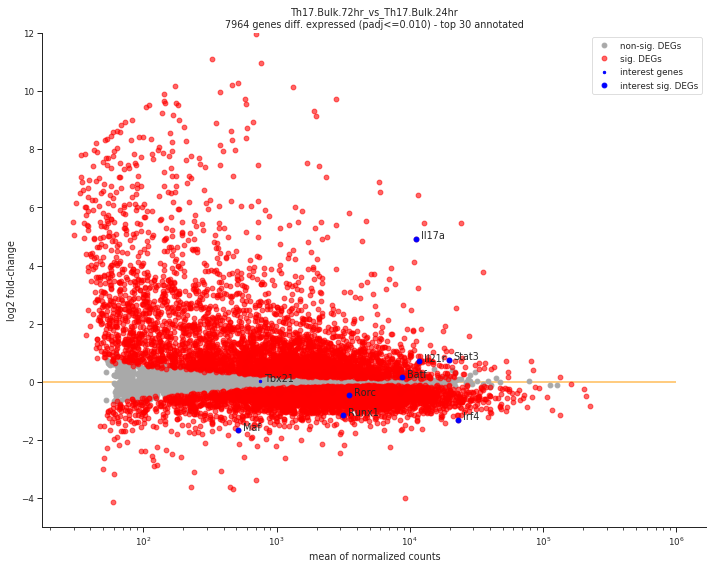

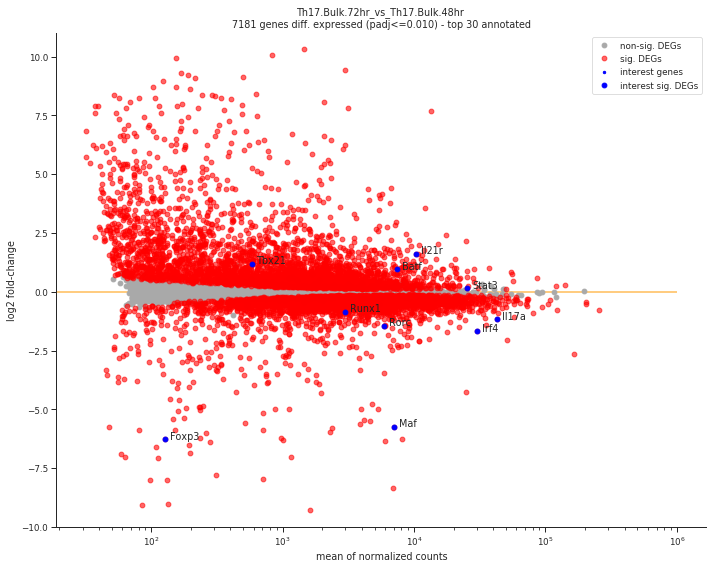

In [14]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.01
top_to_report = 30

special_genes = ['Maf', 'Il17a', 'Rorc', 'Stat3', 'Stat5', 'Batf', 'Irf4', 'Runx1', 'Il21r', 'Tbx21', 'Foxp3']
comparisons = [
     'Th17.Bulk.16hr_vs_Th17.Bulk.02hr',
     'Th17.Bulk.24hr_vs_Th17.Bulk.02hr',  
     'Th17.Bulk.48hr_vs_Th17.Bulk.02hr',
     'Th17.Bulk.72hr_vs_Th17.Bulk.02hr',
     'Th17.Bulk.24hr_vs_Th17.Bulk.16hr',
     'Th17.Bulk.48hr_vs_Th17.Bulk.16hr',
     'Th17.Bulk.72hr_vs_Th17.Bulk.16hr',
     'Th17.Bulk.48hr_vs_Th17.Bulk.24hr',
     'Th17.Bulk.72hr_vs_Th17.Bulk.24hr',
     'Th17.Bulk.72hr_vs_Th17.Bulk.48hr'
]

data_dir = '/data/reddylab/Revathy/dev/rna-seq_Siklenka/pairwise/Th17/deseq2'

for comparison in comparisons:
    df = pd.read_csv("%s/%s.with_genes.txt" % (data_dir, comparison),
                    sep="\t")
#     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
#                     sep="\t",
#                     names=['GeneName', 'GeneType'])
#     df = df.merge(df_gene_name_type, on='GeneName')
#     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
#     df = df[~df.GeneType.isin(pseudogene_types)]
#     df = df[df.GeneType.isin(['protein_coding'])]
    fig = plt.figure(figsize=(10,8))
    ax = plt.subplot(1, 1, 1)
    df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
    ax.set_xscale('log')
    ax.plot(df_non_sig['baseMean'].values, 
            df_non_sig['log2FoldChange'].values, 
            'o', color='darkgrey', label='non-sig. DEGs')

    
    ylims = [np.ceil(df['log2FoldChange'].min()-1), 
             np.floor(df['log2FoldChange'].max()+1)]
    df_sig = df[df.padj<=pval_thres]
    ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.6, label='sig. DEGs')

    # Annotate the top top_to_report
    df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)
    df_annotate_table = df_sig.sort_values(by='padj', ascending=True)

#     if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
#         df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
#     ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', label='sig. DEGs')

#     for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
#         ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
#                     textcoords='offset points')

    # Annotate in particular IL1RN, HBG and EP300
    df_annotate_selected = df[df.GeneName.isin(special_genes)]
    ax.plot(df_annotate_selected['baseMean'].values, 
            df_annotate_selected['log2FoldChange'].values,color='blue', 
            marker='.', linestyle = 'None', alpha=1, label='interest genes')
    for x, y, t in zip(df_annotate_selected['baseMean'].values,
                       df_annotate_selected['log2FoldChange'].values, 
                       df_annotate_selected['GeneName'].values) :
        ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                textcoords='offset points')
    df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
    ax.plot(df_annotate_selected['baseMean'].values, 
            df_annotate_selected['log2FoldChange'].values,color='blue', 
            marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs')
    
    

    plt.ylim(ylims)
    plt.xlabel("mean of normalized counts")
    plt.ylabel("log2 fold-change")
    plt.title("%s\n%d genes diff. expressed (padj<=%.3f) - top %d annotated" % (comparison, 
                                                                                np.count_nonzero(df.padj<=pval_thres), 
                                                                                pval_thres, 
                                                                                top_to_report))
    plt.hlines(0, 0, 1e6, color='#ffcc80', linewidth =2 )
    plt.legend()

    # Remove spines and tight the layout
    simpleaxis(ax)
    plt.tight_layout()
    
#     # Save annotated MA plot
    plt.savefig("/data/reddylab/Revathy/dev/rna-seq_Siklenka/pairwise/Th17/deseq2/degs.%s.with_genes.annotated_plot_MA.png" % comparison)
    
     # Save annotated genes without pseudogenes
    df_annotate_table.to_csv("/data/reddylab/Revathy/dev/rna-seq_Siklenka/pairwise/Th17/deseq2/%s.with_genes.sig_DE.txt" % comparison,
                       sep='\t',
                       index=False)
    
#     # print table of values 
#     print ("======", comparison, "======")
#     display(df_annotate) 
